In [ ]:
# This notebook is used to generate triplet of music attributes (melody) for lyrics in the test data.

In [ ]:
# # when using google drive
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /-/-/-/-/
# !pip install py-midi
# !pip install pretty_midi
# !pip install music-geometry-eval

In [ ]:
import numpy as np
import tensorflow as tf
import midi_statistics
import utils
import pickle
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from models import Diffusion #, UNet_1D
from dilated import DiffWave, DiffWave_wText
from modules import UNet
from torch.utils.data import DataLoader
from dataset import MIDIDataset 
from torchtext.data.metrics import bleu_score
import pickle
import random
import music_geometry_eval
from itertools import groupby

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# Set seed for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### Functions to generate Songs

In [ ]:
def do_generate_songs(model_path, data):
  generated_songs = []

  model_stats = {}
  model_stats['stats_scale_tot'] = 0
  model_stats['stats_repetitions_2_tot'] = 0
  model_stats['stats_repetitions_3_tot'] = 0
  model_stats['stats_span_tot'] = 0
  model_stats['stats_unique_tones_tot'] = 0
  model_stats['stats_avg_rest_tot'] = 0
  model_stats['num_of_null_rest_tot'] = 0
  model_stats['best_scale_score'] = 0
  model_stats['best_repetitions_2'] = 0
  model_stats['best_repetitions_3'] = 0
  model_stats['num_perfect_scale'] = 0
  model_stats['num_good_songs'] = 0
  model_stats['avg_songlength'] = 0

  with tf.compat.v1.Session(graph=tf.Graph()) as sess:
      tf.compat.v1.saved_model.loader.load(sess, [], model_path)
      graph = tf.compat.v1.get_default_graph()
      keep_prob = graph.get_tensor_by_name("model/keep_prob:0")
      input_metadata = graph.get_tensor_by_name("model/input_metadata:0")
      input_songdata = graph.get_tensor_by_name("model/input_data:0")
      output_midi = graph.get_tensor_by_name("output_midi:0")
      feed_dict = {}
      feed_dict[keep_prob.name] = 1
      condition = []
      feed_dict[input_metadata.name] = condition


      for i in range(len(data)):
          feed_dict[input_songdata.name] = np.random.uniform(size=(1, 20, 3))
          condition.append(np.split(data[i][3 * 20:], 20))
          feed_dict[input_metadata.name] = condition
          generated_features = sess.run(output_midi, feed_dict)
          sample = [x[0, :] for x in generated_features]
          sample = midi_statistics.tune_song(utils.discretize(sample))
          generated_songs.append(sample)
          condition = []

          # get stats
          stats = midi_statistics.get_all_stats(sample)
          model_stats['stats_scale_tot'] += stats['scale_score']
          model_stats['stats_repetitions_2_tot'] += float(stats['repetitions_2'])
          model_stats['stats_repetitions_3_tot'] += float(stats['repetitions_3'])
          model_stats['stats_unique_tones_tot'] += float(stats['tones_unique'])
          model_stats['stats_span_tot'] += stats['tone_span']
          model_stats['stats_avg_rest_tot'] += stats['average_rest']
          model_stats['num_of_null_rest_tot'] += stats['num_null_rest']
          model_stats['best_scale_score'] = max(stats['scale_score'], model_stats['best_scale_score'])
          model_stats['best_repetitions_2'] = max(stats['repetitions_2'], model_stats['best_repetitions_2'])
          model_stats['best_repetitions_3'] = max(stats['repetitions_3'], model_stats['best_repetitions_3'])
          model_stats['avg_songlength'] += stats['songlength']

          if stats['scale_score'] == 1.0 and stats['tones_unique'] > 3 \
              and stats['tone_span'] > 4 and stats['num_null_rest'] > 8 and stats['tone_span'] < 13\
              and stats['repetitions_2'] > 4:
              model_stats['num_good_songs'] += 1
      
      model_stats['avg_songlength'] /= len(data)

  return generated_songs, model_stats

In [ ]:
def get_model_stats(model, diffusion, dataloader, dataset):
        
    model_stats = {}
    model_stats['stats_scale_tot'] = 0
    model_stats['stats_repetitions_2_tot'] = 0
    model_stats['stats_repetitions_3_tot'] = 0
    model_stats['stats_span_tot'] = 0
    model_stats['stats_unique_tones_tot'] = 0
    model_stats['stats_avg_rest_tot'] = 0
    model_stats['num_of_null_rest_tot'] = 0
    model_stats['best_scale_score'] = 0
    model_stats['best_repetitions_2'] = 0
    model_stats['best_repetitions_3'] = 0
    model_stats['num_perfect_scale'] = 0
    model_stats['num_good_songs'] = 0
    model_stats['avg_songlength'] = 0
    
    validation_songs = []
    for (midi_tuples, syllable_embs) in dataloader:
        #midi_tuples = midi_tuples.to(device)
        #midi_tuples = midi_tuples.squeeze(2)

        sampled_melodies = diffusion.sample_1d_wText(model, syllable_embs, n=syllable_embs.shape[0]).cpu().detach()
        
        for i, sampled_melody in enumerate(sampled_melodies):
            sampled_melody = sampled_melody.transpose(1, 0).numpy() # -> [melody len, 3]
            denormed_melody = dataset.denormalize2(sampled_melody)

            #denormed_melody = np.concatenate((denormed_melody, np.ones(denormed_melody.shape), np.zeros(denormed_melody.shape)), axis=1)
            denormed_melody = dataset.discretize(denormed_melody)
            tuned_melody = midi_statistics.tune_song(denormed_melody)

            validation_songs.append(tuned_melody)

            stats = midi_statistics.get_all_stats(tuned_melody)
            model_stats['stats_scale_tot'] += stats['scale_score']
            model_stats['stats_repetitions_2_tot'] += float(stats['repetitions_2'])
            model_stats['stats_repetitions_3_tot'] += float(stats['repetitions_3'])
            model_stats['stats_unique_tones_tot'] += float(stats['tones_unique'])
            model_stats['stats_span_tot'] += stats['tone_span']
            model_stats['stats_avg_rest_tot'] += stats['average_rest']
            model_stats['num_of_null_rest_tot'] += stats['num_null_rest']
            model_stats['best_scale_score'] = max(stats['scale_score'], model_stats['best_scale_score'])
            model_stats['best_repetitions_2'] = max(stats['repetitions_2'], model_stats['best_repetitions_2'])
            model_stats['best_repetitions_3'] = max(stats['repetitions_3'], model_stats['best_repetitions_3'])
            model_stats['avg_songlength'] += stats['songlength']

            # if stats['scale_score'] == 1.0:
            #    model_stats['num_perfect_scale'] += 1

            if stats['scale_score'] == 1.0 and stats['tones_unique'] > 3 \
               and stats['tone_span'] > 4 and stats['num_null_rest'] > 8 and stats['tone_span'] < 13\
               and stats['repetitions_2'] > 4:
                model_stats['num_good_songs'] += 1
    model_stats['avg_songlength'] /= len(validation_songs)

    return validation_songs, model_stats

In [ ]:
def do_generate_songs_diff(model_path, dataloader, dataset):
    lr = 9e-4
    diffusion = Diffusion()
    model = DiffWave_wText(device=device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = torch.nn.MSELoss()

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model'])
    optimizer.load_state_dict(state_dict['optimizer'])
    print('Model loaded!', model_path)
    
    return get_model_stats(model, diffusion, dataloader, dataset)

In [ ]:
train_data = np.load('./data/processed_dataset_matrices/train_data_matrix.npy')
valid_data = np.load('./data/processed_dataset_matrices/valid_data_matrix.npy')
test_data = np.load('./data/processed_dataset_matrices/test_data_matrix.npy')

train_data.shape, valid_data.shape, test_data.shape

((11149, 460), (1051, 460), (1051, 460))

In [ ]:
NUM_MIDI_FEATURES = 3
NUM_SYLLABLE_FEATURES = 20
SONGLENGTH = 20
BATCH_SIZE = 256
TRAIN_DATA_MATRIX = "data/processed_dataset_matrices/train_data_matrix.npy"
VALIDATE_DATA_MATRIX = "data/processed_dataset_matrices/valid_data_matrix.npy"
TEST_DATA_MATRIX = "data/processed_dataset_matrices/test_data_matrix.npy"

In [ ]:
train = np.load(TRAIN_DATA_MATRIX)
validate = np.load(VALIDATE_DATA_MATRIX)
test = np.load(TEST_DATA_MATRIX)

print("Training set: ", np.shape(train)[0], " songs, Validation set: ", np.shape(validate)[0], " songs, "
      "Test set: ", np.shape(test)[0], " songs.")

Training set:  11149  songs, Validation set:  1051  songs, Test set:  1051  songs.


In [ ]:
dataset_train = MIDIDataset(train_data, NUM_MIDI_FEATURES, SONGLENGTH, NUM_SYLLABLE_FEATURES)
dataset_valid = MIDIDataset(valid_data, NUM_MIDI_FEATURES, SONGLENGTH, NUM_SYLLABLE_FEATURES)
dataset_test = MIDIDataset(test_data, NUM_MIDI_FEATURES, SONGLENGTH, NUM_SYLLABLE_FEATURES)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=True)

Num samples: 11149
Num samples: 1051
Num samples: 1051


In [ ]:
def get_all_stats_from_array(d_midi):
    _num_midi_features = 3
    _seq_length = int(len(d_midi) / _num_midi_features)
    stats = {}
    tones = []
    note_type = []
    rest = []
    for i in range(_seq_length):
        tones.append(d_midi[i*_num_midi_features+0])
    for i in range(_seq_length):
        note_type.append(d_midi[i*_num_midi_features+1])
    for i in range(_seq_length):
        rest.append(d_midi[i*_num_midi_features+2])
    if len(tones) == 0:
        print('This is an empty song.')
        return None
    stats['num_tones'] = len(tones)
    stats['tone_min'] = min(tones)
    stats['tone_max'] = max(tones)
    stats['tone_span'] = max(tones)-min(tones)
    stats['tones_unique'] = len(set(tones))
    rs = midi_statistics.repetitions(tones)
    for r in range(2, 10):
        if r in rs:
          stats['repetitions_{}'.format(r)] = rs[r]
        else:
          stats['repetitions_{}'.format(r)] = 0
    ml = midi_statistics.max_likelihood_scale(tones)
    stats['scale'] = ml[0]
    stats['scale_score'] = ml[1]
    stats['rest_max'] = max(rest)
    stats['average_rest'] = np.mean(rest)
    stats['num_null_rest'] = rest.count(0)
    stats['songlength'] = sum(rest) + sum(note_type)

    return stats

In [ ]:
def analyze_ground_truth(data):
  # for each data[i], data[i][:60] is the midi data. the rest is the lyrics data
  model_stats = {}
  model_stats['stats_scale_tot'] = 0
  model_stats['stats_repetitions_2_tot'] = 0
  model_stats['stats_repetitions_3_tot'] = 0
  model_stats['stats_span_tot'] = 0
  model_stats['stats_unique_tones_tot'] = 0
  model_stats['stats_avg_rest_tot'] = 0
  model_stats['num_of_null_rest_tot'] = 0
  model_stats['best_scale_score'] = 0
  model_stats['best_repetitions_2'] = 0
  model_stats['best_repetitions_3'] = 0
  model_stats['num_perfect_scale'] = 0
  model_stats['num_good_songs'] = 0
  model_stats['avg_songlength'] = 0

  for d in data:
    d_midi = d[:60]
    stats = get_all_stats_from_array(d_midi)
    # get stats
    model_stats['stats_scale_tot'] += stats['scale_score']
    model_stats['stats_repetitions_2_tot'] += float(stats['repetitions_2'])
    model_stats['stats_repetitions_3_tot'] += float(stats['repetitions_3'])
    model_stats['stats_unique_tones_tot'] += float(stats['tones_unique'])
    model_stats['stats_span_tot'] += stats['tone_span']
    model_stats['stats_avg_rest_tot'] += stats['average_rest']
    model_stats['num_of_null_rest_tot'] += stats['num_null_rest']
    model_stats['best_scale_score'] = max(stats['scale_score'], model_stats['best_scale_score'])
    model_stats['best_repetitions_2'] = max(stats['repetitions_2'], model_stats['best_repetitions_2'])
    model_stats['best_repetitions_3'] = max(stats['repetitions_3'], model_stats['best_repetitions_3'])
    model_stats['avg_songlength'] += stats['songlength']

    if stats['scale_score'] == 1.0 and stats['tones_unique'] > 3 \
        and stats['tone_span'] > 4 and stats['num_null_rest'] > 8 and stats['tone_span'] < 13\
        and stats['repetitions_2'] > 4:
        model_stats['num_good_songs'] += 1
    
  model_stats['avg_songlength'] /= len(data)

  return model_stats

In [ ]:
def get_ground_truth_music(data):
    return data[:,:60]

In [ ]:
def get_bleu_score(gen_data, ref_data):
    gen_pitches = np.zeros((np.shape(gen_data)[0],SONGLENGTH))
    ref_pitches = np.zeros((np.shape(ref_data)[0],SONGLENGTH))
    gen_duration = np.zeros((np.shape(gen_data)[0],SONGLENGTH))
    ref_duration = np.zeros((np.shape(ref_data)[0],SONGLENGTH))
    gen_rests = np.zeros((np.shape(gen_data)[0],SONGLENGTH))
    ref_rests = np.zeros((np.shape(ref_data)[0],SONGLENGTH))

    for i in range(SONGLENGTH):
        gen_pitches[:, i] = np.array(gen_data)[:, i, 0]
        gen_duration[:, i] = np.array(gen_data)[:, i, 1]
        gen_rests[:, i] = np.array(gen_data)[:, i, 2]
        ref_pitches[:, i] = np.array(ref_data)[:, NUM_MIDI_FEATURES * i]
        ref_duration[:, i] = np.array(ref_data)[:, NUM_MIDI_FEATURES * i + 1]
        ref_rests[:, i] = np.array(ref_data)[:, NUM_MIDI_FEATURES * i + 2]

    ref_pitches = np.expand_dims(ref_pitches,axis=1)
    ref_duration = np.expand_dims(ref_duration,axis=1)
    ref_rests = np.expand_dims(ref_rests,axis=1)
    bleu_pitches = bleu_score(gen_pitches.astype(str), ref_pitches.astype(str))
    bleu_duration = bleu_score(gen_duration.astype(str), ref_duration.astype(str))
    bleu_rests = bleu_score(gen_rests.astype(str), ref_rests.astype(str))
    bleu_sum = bleu_pitches + bleu_duration + bleu_rests
    print(f"BLEU: pitch - {bleu_pitches}, duration - {bleu_duration}, rests - {bleu_rests}, sum - {bleu_sum}")  
    
    return bleu_pitches, bleu_duration, bleu_rests, bleu_sum

In [ ]:
def report_stat(stat, name):
    print(f"======= [{name}] ========")
    print(f"MIDI numbers span: {stat['stats_span_tot']}")
    print(f"3-MIDI-number repetitions: {stat['stats_repetitions_3_tot']}")
    print(f"2-MIDI-number repetitions: {stat['stats_repetitions_2_tot']}")
    print(f"# Unique MIDI numbers: {stat['stats_unique_tones_tot']}")
    print(f"# Notes without rest: {stat['num_of_null_rest_tot']}")
    print(f"Avg rest value within a song: {stat['stats_avg_rest_tot']}")
    print(f"Song length(average): {stat['avg_songlength']}")
    print(f"Number of Good Songs: {stat['num_good_songs']}")
    print("\n")

In [ ]:
def compare_stat(stat1, stat2):
    for key in stat1:
        print(f"{key}: {stat1[key] - stat2[key]}")

### Loading Models, Generate Songs with Test Data

In [ ]:
# ground truth
test_gt_stats = analyze_ground_truth(test_data)
test_gt_songs = get_ground_truth_music(test_data)

# baseline
base_model_path = 'saved_gan_models/saved_model_best_overall_mmd'
test_gen_songs_bl, test_model_stats_bl = do_generate_songs(base_model_path, test_data)
test_gen_songs_bl = np.asarray(test_gen_songs_bl)
print(test_gen_songs_bl.shape)

# our model
our_model_path = 'saved_models/saved_model'
test_gen_songs_om_sm, test_model_stats_om_sm = do_generate_songs_diff(our_model_path, dataloader_test, dataset_test)
test_gen_songs_om_sm = np.asarray(test_gen_songs_om_sm)

##### trash

In [ ]:
######
#valid_gt_stats = analyze_ground_truth(valid_data)
#train_gt_stats = analyze_ground_truth(train_data)
#valid_gen_songs_bl, valid_model_stats_bl = do_generate_songs(base_model_path, valid_data)
#train_gen_songs_bl, train_model_stats_bl = do_generate_songs(base_model_path, train_data)
#valid_gen_songs_bl = np.asarray(valid_gen_songs_bl)
# our_model_path = 'saved_models/saved_model_best_overall_mmd'
# test_gen_songs_om, test_model_stats_om = do_generate_songs_diff(our_model_path, dataloader_test, dataset_test)
# valid_gen_songs_om, valid_model_stats_om = do_generate_songs_diff(our_model_path, dataloader_valid, dataset_valid)
# test_gen_songs_om = np.asarray(test_gen_songs_om)
# valid_get_songs_om = np.asarray(valid_gen_songs)
# test_gen_songs_om.shape, valid_get_songs_om.shape
# our_model_path = 'saved_models/saved_model_best_bleu_sum'
# test_gen_songs_om_bleu, test_model_stats_om_bleu = do_generate_songs_diff(our_model_path, dataloader_test, dataset_test)
# valid_gen_songs_om_bleu, valid_model_stats_om_bleu = do_generate_songs_diff(our_model_path, dataloader_valid, dataset_valid)
#valid_gen_songs_om_sm, valid_model_stats_om_sm = do_generate_songs_diff(our_model_path, dataloader_valid, dataset_valid)
#valid_gen_songs_om_sm = np.asarray(valid_gen_songs_om_sm)

In [ ]:
# def get_cmm(d_midi):
#     # Conjunct Melodic Motion
#     _num_midi_features = 3
#     _seq_length = int(len(d_midi) / _num_midi_features)
#     tones = []
#     for i in range(_seq_length):
#         tone = d_midi[i*_num_midi_features+0]
#         tones.append(tone)
#     if len(tones) == 0:
#         print("This is an empty song.")
#         return None

In [ ]:
# def drawhist(name, func):
#     print(f"[{name}]")
#     print("Our Model- ")
#     om = func(test_gen_songs_om_sm)
#     plt.imshow(om.reshape(12,-1).T)
#     plt.show()

#     print("Baseline- ")
#     bl = func(test_gen_songs_bl)
#     plt.imshow(bl.reshape(12,-1).T)
#     plt.show()

#     print("Ground Truth - ")
#     gt = func(test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3))
#     plt.imshow(gt.reshape(12,-1).T)
#     plt.show()

## New Evaluation Metric

#### PRINTOUTS

In [ ]:
def print_stats(stat):
    print(f"avg: {np.average(stat)}, std: {np.std(stat)}, max: {np.max(stat)}, min: {np.min(stat)}")

def printoutstat(name, func):
    print(f"[{name}]")
    print("Our Model- ")
    om = func(test_gen_songs_om_sm)
    print_stats(om)

    print("Baseline- ")
    bl = func(test_gen_songs_bl)
    print_stats(bl)

    print("Ground Truth - ")
    gt = func(test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3))
    print_stats(gt)

#### Notes
##### Evaluate CMM(Conjunct Melodic Motion)
 - CMM looks for smooth transitions through the melody.

##### Evaluate Limited Macroharmony
 - Macroharmy measures the diversity of notes in melodies. This is captured by measuring the number of different notes in short slices of time(spans).
 - modified: the original one measures based on short slices of time (spans) and it's modeled on the length of the music. but since our music is small. It is not too big harm to measure based on the whole 20 notes
 - According to Tymoczko, tonal melodies must have between 5 and 8 different notes since the number of alternatives a human can manage is 7+-2 [Miller, 1956]

##### Centricity
 - Centricity claims that in short slices of time (spans), there must be a note which appears with more frequency than the others.

#### no need (own implementation for CMM, LM, Centricity) ####

In [ ]:
# def get_cmms(songs):
#     cmms = []
#     for song in songs:
#         _pitches = np.array(song)[:,0]
#         _diff_sum = np.sum(np.abs(_pitches[1:] - _pitches[:-1]))
#         _cmm = _diff_sum / (len(song) - 1)
#         cmms.append(_cmm)
#     return cmms

In [ ]:
# print("[Evaluate CMM: the lower the better]")
# print("Our Model - ")
# om_cmms = get_cmms(test_gen_songs_om_sm)
# print_stats(om_cmms)

# print("Baseline - ")
# bl_cmms = get_cmms(test_gen_songs_bl)
# print_stats(bl_cmms)

# print("Ground Truth - ")
# gt_cmms = get_cmms(test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3))
# print_stats(gt_cmms)

[Evaluate CMM: the lower the better]
Our Model - 
avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
Baseline - 
avg: 1.6066402924533025, std: 0.4707232433243068, max: 3.3684210526315788, min: 0.42105263157894735
Ground Truth - 
avg: 2.3950122690169766, std: 1.4904866871175466, max: 23.473684210526315, min: 0.0


In [ ]:
# def get_num_distinct_notes(songs):
#     distincts = []
#     for song in songs:
#         _pitches = np.array(song)[:,0]
#         _distinct = np.unique(_pitches).shape[0]
#         distincts.append(_distinct)
#     return distincts

# def get_limited_macroharmony(songs):
#     distincts = get_num_distinct_notes(songs)
#     _lb = 5
#     _ub = 8
#     lms = np.zeros(len(distincts))
#     for i, dist in enumerate(distincts):
#         if dist in range(5,9):   # if it's within the appropriate limit, 1
#             lms[i] = 1
#         elif dist < _lb:   # if lower than lower bound, 1 + the diff
#             lms[i] = (_lb - dist) + 1
#         else:              # if bigger than upper bound, 1 + the diff
#             lms[i] = (dist - _ub) + 1
#     return lms

In [ ]:
# print("[Evaluate Limited Macroharmony: the lower the better]")
# print("Our Model- ")
# om_lms = get_limited_macroharmony(test_gen_songs_om_sm)
# print_stats(om_lms)

# print("Baseline- ")
# bl_lms = get_limited_macroharmony(test_gen_songs_bl)
# print_stats(bl_lms)

# print("Ground Truth - ")
# gt_lms = get_limited_macroharmony(test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3))
# print_stats(gt_lms)

[Evaluate Limited Macroharmony: the lower the better]
Our Model- 
avg: 1.1769743101807801, std: 0.5078665459105981, max: 6.0, min: 1.0
Baseline- 
avg: 1.3805899143672693, std: 0.810119180630243, max: 8.0, min: 1.0
Ground Truth - 
avg: 1.5033301617507135, std: 0.9216387715103804, max: 8.0, min: 1.0


In [ ]:
# def get_centricity(songs):
#     centrics = []
#     for song in songs:
#         _pitches = np.array(song)[:,0]
#         _distinct, _counts = np.unique(_pitches, return_counts = True)
#         _cent = np.max(_counts)
#         _centric = _cent / len(song)
#         #centrics.append(_centric)
#         val = 0
#         if _centric >= 0.2:
#             val = 1
#         else:
#             val = 1 + (0.2-_centric)*10
#         centrics.append(val)
#     return centrics

In [ ]:
# print("[Evaluate Centricity: the lower the better]")
# print("Our Model- ")
# om_ctr = get_centricity(test_gen_songs_om_sm)
# print_stats(om_ctr)

# print("Baseline- ")
# bl_ctr = get_centricity(test_gen_songs_bl)
# print_stats(bl_ctr)

# print("Ground Truth - ")
# gt_ctr = get_centricity(test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3))
# print_stats(gt_ctr)

[Evaluate Centricity: the lower the better]
Our Model- 
avg: 1.0033301617507135, std: 0.04066928691372506, max: 1.5000000000000002, min: 1.0
Baseline- 
avg: 1.0085632730732637, std: 0.06844007805272864, max: 2.0, min: 1.0
Ground Truth - 
avg: 1.0052331113225499, std: 0.055361607636699506, max: 2.0, min: 1.0


#### Using library

In [ ]:
#fixed because of the bug

def calculate_time_supported_limited_macroharmony(time_rep_song, span_size=12, slide_windowsize=4):
  """
  calculates the metric over 16th notes grids with a moving window of a quarter
  note (4)
  """
  grid_16th_song = music_geometry_eval.time_rep_song_to_16th_note_grid(time_rep_song)
  lower_limit = 5
  upper_limit = 8

  def local_lim_macrohar(song, lower_limit, upper_limit):
    # ignore 0s
    song = [elem for elem in song if elem != 0 ]
    number_of_notes = len(set(song))
    if lower_limit <= number_of_notes <= upper_limit:
      return 1
    elif number_of_notes < lower_limit:
      return (lower_limit - number_of_notes) + 1
    else:
      return (number_of_notes - lower_limit) + 1

  if len(grid_16th_song) <= span_size:
    result = local_lim_macrohar(grid_16th_song, lower_limit, upper_limit)
  else:
    number_of_spans = int((len(grid_16th_song) - span_size)/slide_windowsize + 1)

    span_scores = []
    for i in range(number_of_spans):
      span_scores.append(local_lim_macrohar(grid_16th_song[i*slide_windowsize:i*slide_windowsize + span_size], lower_limit, upper_limit))

    result = sum(span_scores)/float(number_of_spans)

  return float(result)
 
def calculate_time_supported_centricity(time_rep_song, span_size=12, slide_windowsize=4):
  """
  calculates the metric over 16th notes grids with a moving window of a quarter
  note (4)
  """
  grid_16th_song = music_geometry_eval.time_rep_song_to_16th_note_grid(time_rep_song)

	# just the frecuency, making the metric more descriptive
  def local_centricity_simple(song): # ignore 0s
    song = [elem for elem in song if elem != 0 ]
    notes_group = [len(list(group)) for key, group in groupby(song)]
    if len(song) == 0:
      return 0

    group_sum = float(sum(notes_group))
    frecuencies = [a/group_sum for a in notes_group]

    cental_note_frec = max(frecuencies)

    return cental_note_frec

  if len(grid_16th_song) <= span_size:
    result = local_centricity_simple(grid_16th_song)
  else:
    number_of_spans = int((len(grid_16th_song) - span_size)/slide_windowsize + 1)

    span_scores = []
    for i in range(number_of_spans):

      span_scores.append(local_centricity_simple(grid_16th_song[i*slide_windowsize:i*slide_windowsize + span_size]))

    result = sum(span_scores)/float(number_of_spans)


  return float(result)

In [ ]:
def get_geostat(songs, span_size=20, time=False):
  # default span_size = 20 (= our music size). generally the default span_size is 12
  cmms = []
  lms = []
  cents = []
  gentons = []

  for song in songs:
    if time:
      _cmm = music_geometry_eval.calculate_time_supported_conjunct_melodic_motion(song)
      _lm = calculate_time_supported_limited_macroharmony(song, span_size=span_size)
      _cent = calculate_time_supported_centricity(song, span_size=span_size)
      _genton = music_geometry_eval.calculate_general_tonality(_cmm, _lm, _cent)
    else:
      _cmm = music_geometry_eval.calculate_conjunct_melodic_motion(song)
      _lm = music_geometry_eval.calculate_limited_macroharmony(song, span_size=span_size)
      _cent = music_geometry_eval.calculate_centricity(song, span_size=span_size)
      _genton = music_geometry_eval.calculate_general_tonality(_cmm, _lm, _cent)
    cmms.append(_cmm)
    lms.append(_lm)
    cents.append(_cent)
    gentons.append(_genton)

  return cmms, lms, cents, gentons

In [ ]:
def calcNprint_geostats(name, songs, span_size=20, time=False):
  if time:
    _songs = np.copy(songs[:,:,0:2])
    _songs[:,:,1] *= 4
    _songs = _songs.astype('int')
    cmms, lms, cents, gentons = get_geostat(_songs, span_size=span_size, time=time)
  else:
    _songs = songs[:,:,0]
    cmms, lms, cents, gentons = get_geostat(_songs, span_size=span_size, time=time)

  print(f"[{name}]")
  print(f"- CMM: ", end=' ')
  print_stats(cmms)
  print(f"- LM: ", end=' ')
  print_stats(lms)
  print(f"- CENTRICITY: ", end=' ')
  print_stats(cents)
  #print(f"- CENTRICITY(ratio of good song - at least 20% of melody): {np.sum(np.array(cents)>=0.2)/len(cents)}")
  cents = np.array(cents)
  print(f"- CENTRICITY(ratio of good song): {(np.sum(cents >=0.08) - np.sum(cents >=0.32))/len(cents)}")
  print(f"- General Tonality: ", end=' ')
  print_stats(gentons)

In [ ]:
_SPAN=20
print(f"With Span Size {_SPAN} (Our Song Size)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN)

With Span Size 20 (Our Song Size)
[Our Model]
- CMM:  avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
- LM:  avg: 1.5394862036156043, std: 1.437936240032768, max: 9.0, min: 1.0
- CENTRICITY:  avg: 0.1400570884871551, std: 0.04558110445607431, max: 0.4, min: 0.05
- CENTRICITY(ratio of good song): 0.9819219790675547
- General Tonality:  avg: 4.365356302268516, std: 1.8543769977255287, max: 16.257894736842108, min: 2.3052631578947373
[Baseline]
- CMM:  avg: 1.6066402924533025, std: 0.4707232433243068, max: 3.3684210526315788, min: 0.42105263157894735
- LM:  avg: 1.7973358705994291, std: 1.716276960065436, max: 11.0, min: 1.0
- CENTRICITY:  avg: 0.19500475737392958, std: 0.07883110718342798, max: 0.8, min: 0.1
- CENTRICITY(ratio of good song): 0.9381541389153187
- General Tonality:  avg: 3.5989809204266607, std: 1.906563337600772, max: 13.73157894736842, min: 1.8842105263157893
[Ground Truth]
- CMM:  avg: 2.3950122690169766, std: 1.490486687

In [ ]:
_SPAN=10
print(f"With Span Size {_SPAN} (Half of Our Song Size)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN)

With Span Size 10 (Half of Our Song Size)
[Our Model]
- CMM:  avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
- LM:  avg: 1.3453853472882968, std: 0.4096468978991105, max: 3.6363636363636362, min: 1.0
- CENTRICITY:  avg: 0.23069803650203266, std: 0.06341466288689941, max: 0.6090909090909091, min: 0.09999999999999999
- CENTRICITY(ratio of good song): 0.9219790675547098
- General Tonality:  avg: 4.261896393956086, std: 0.653903860885832, max: 10.930622009569378, min: 2.7100478468899523
[Baseline]
- CMM:  avg: 1.6066402924533025, std: 0.4707232433243068, max: 3.3684210526315788, min: 0.42105263157894735
- LM:  avg: 2.0320041518899754, std: 0.6443866525301638, max: 4.454545454545454, min: 1.0
- CENTRICITY:  avg: 0.3090130611538794, std: 0.09747781496970723, max: 0.9090909090909091, min: 0.11818181818181818
- CENTRICITY(ratio of good song): 0.6412940057088488
- General Tonality:  avg: 3.947657505497157, std: 0.5575105657856986, max: 6.0483253

In [ ]:
_SPAN=12
print(f"With Span Size {_SPAN} (Default of music_geometry_eval)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN)

With Span Size 12 (Default of music_geometry_eval)
[Our Model]
- CMM:  avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
- LM:  avg: 1.2226450999048526, std: 0.40979171244410917, max: 5.222222222222222, min: 1.0
- CENTRICITY:  avg: 0.20348345491066708, std: 0.06055922876851218, max: 0.6018518518518517, min: 0.08333333333333333
- CENTRICITY(ratio of good song): 0.9476688867745005
- General Tonality:  avg: 4.111941564981277, std: 0.7690166904720704, max: 12.500487329434698, min: 2.6710526315789473
[Baseline]
- CMM:  avg: 1.6066402924533025, std: 0.4707232433243068, max: 3.3684210526315788, min: 0.42105263157894735
- LM:  avg: 1.8226028121365896, std: 0.6838445505119272, max: 5.666666666666667, min: 1.0
- CENTRICITY:  avg: 0.27603340733692777, std: 0.0971768816719204, max: 0.9074074074074073, min: 0.10185185185185186
- CENTRICITY(ratio of good song): 0.7469077069457659
- General Tonality:  avg: 3.70527651192682, std: 0.6681744857870245, max: 

In [ ]:
# with time
_SPAN=12
print(f"With Time, With Span Size {_SPAN} (Default of music_geometry_eval)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN, time=True)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN, time=True)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN, time=True)

With Time, With Span Size 12 (Default of music_geometry_eval)
[Our Model]
- CMM:  avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
- LM:  avg: 4.045145363576778, std: 0.8053607331738564, max: 5.2926829268292686, min: 1.0
- CENTRICITY:  avg: 0.6070146335649864, std: 0.16016506084443768, max: 0.9375, min: 0.08888888888888889
- General Tonality:  avg: 7.337973007307522, std: 1.144740622709295, max: 11.574561403508772, min: 3.306448412698413
[Baseline]
- CMM:  avg: 1.5915168511192348, std: 0.4745293680956302, max: 3.473684210526316, min: 0.3157894736842105
- LM:  avg: 3.853587868404044, std: 0.3249120258119755, max: 4.705882352941177, min: 2.0
- CENTRICITY:  avg: 0.580171661507136, std: 0.09558677510675738, max: 0.890625, min: 0.28444444444444444
- General Tonality:  avg: 6.025276381030414, std: 0.41213257430033856, max: 7.799932523616734, min: 4.021286549707602
[Ground Truth]
- CMM:  avg: 2.3950122690169766, std: 1.4904866871175466, max: 23.

In [ ]:
_SPAN=10
print(f"With Time, With Span Size {_SPAN} (Half of Our Song Size)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN, time=True)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN, time=True)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN, time=True)
_SPAN=20
print(f"With Time, With Span Size {_SPAN} (Our Song Size)")
calcNprint_geostats("Our Model", test_gen_songs_om_sm, span_size=_SPAN, time=True)
calcNprint_geostats("Baseline", test_gen_songs_bl, span_size=_SPAN, time=True)
calcNprint_geostats("Ground Truth", test_gt_songs.reshape(test_gt_songs.shape[0], 20, 3), span_size=_SPAN, time=True)

With Time, With Span Size 10 (Half of Our Song Size)
[Our Model]
- CMM:  avg: 2.6858130101657567, std: 0.7233241779471878, max: 7.157894736842105, min: 1.105263157894737
- LM:  avg: 4.285227257527053, std: 0.7423450895550624, max: 5.5, min: 1.0
- CENTRICITY:  avg: 0.6337959143655588, std: 0.15183398456395786, max: 0.9387755102040817, min: 0.10625000000000001
- General Tonality:  avg: 7.60483618205837, std: 1.0881464757698418, max: 12.145074224021592, min: 3.875530492898914
[Baseline]
- CMM:  avg: 1.5915168511192348, std: 0.4745293680956302, max: 3.473684210526316, min: 0.3157894736842105
- LM:  avg: 4.089823596963274, std: 0.2939257072794827, max: 4.8125, min: 2.0
- CENTRICITY:  avg: 0.631007617187126, std: 0.0922167755784771, max: 0.8958333333333333, min: 0.3159863945578231
- General Tonality:  avg: 6.312348065269635, std: 0.432463963770675, max: 8.267881241565453, min: 4.063032581453634
[Ground Truth]
- CMM:  avg: 2.3950122690169766, std: 1.4904866871175466, max: 23.473684210526315, 

#### Pitch-based features
- PC(Pitch count): The number of different pitches within a sample. The output is a scalar for each sample.
- PCH(Pitch class histogram): The pitch class histogram is an octave-independent representation of the pitch content with a dimensionality of 12 for a chromatic scale [4, 40]. In our case, it represents the octave-independent chromatic quantization of the frequency continuum.
- Pitch class transition matrix (PCTM): The transition of pitch classes contains useful information for tasks such as key detection [30, 53], chord recognition [31], or genre pattern recognition [10]. The two-dimensional pitch class transition matrix is a histogram-like representation computed by counting the pitch transitions for each (ordered) pair of notes. The resulting feature dimensionality is 12 × 12.
- Pitch range (PR): The pitch range is calculated by subtraction of the highest and lowest used pitch in semitones. The output is a scalar for each sample.
- Average pitch interval (PI): Average value of the interval between two consecutive pitches in semitones. The output is a scalar for each sample.

In [ ]:
# def get_PC(songs):
#     pcs = []
#     for song in songs:
#         _pitches = np.array(song)[:,0]
#         _distinct = np.unique(_pitches).shape[0]
#         pcs.append(_distinct)
#     return pcs

# def get_PCH(songs):
#     # octave-independent chromatic scale
#     # determined by pitch value % 12
#     pchs = []
#     for song in songs:
#         _pitches = np.array(song)[:,0]
#         _pitch_classes = _pitches%12
#         _hist, _ = np.histogram(_pitch_classes, bins=12, range=(0,12))
#         pchs.append(_hist)
#     pchs = np.array(pchs)
#     avg_pchs = np.average(pchs, axis=0)
#     return avg_pchs

In [ ]:
# printoutstat("PC", get_PC)

[PC]
Our Model- 
avg: 6.949571836346337, std: 1.318941747510744, max: 13, min: 4
Baseline- 
avg: 6.472882968601332, std: 1.7890610533255416, max: 13, min: 3
Ground Truth - 
avg: 5.883920076117983, std: 1.9272788232372988, max: 15, min: 1


[PCH]
Our Model- 


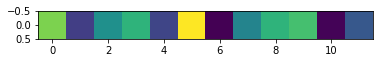

Baseline- 


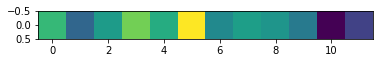

Ground Truth - 


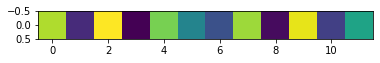

In [ ]:
# drawhist("PCH", get_PCH)

# PAST

In [ ]:
# valid_gen_songs_om_bleu = np.asarray(valid_gen_songs_om_bleu)
# test_gen_songs_om_bleu = np.asarray(test_gen_songs_om_bleu)

In [ ]:
# get_bleu_score(valid_gen_songs_om_bleu, valid_gt_songs)
# get_bleu_score(test_gen_songs_om_bleu, test_gt_songs)

BLEU: pitch - 0.013158297166228294, duration - 0.05960433930158615, rests - 0.5116137862205505, sum - 0.584376422688365
BLEU: pitch - 0.017623169347643852, duration - 0.06952233612537384, rests - 0.5041983127593994, sum - 0.5913438182324171


(0.017623169347643852,
 0.06952233612537384,
 0.5041983127593994,
 0.5913438182324171)

In [ ]:
# # rerun (Nov 30)
# get_bleu_score(valid_gen_songs_om_sm, valid_gt_songs)

BLEU: pitch - 0.01707729697227478, duration - 0.07042541354894638, rests - 0.5277286767959595, sum - 0.6152313873171806


(0.01707729697227478,
 0.07042541354894638,
 0.5277286767959595,
 0.6152313873171806)

In [ ]:
get_bleu_score(test_gen_songs_om_sm, test_gt_songs)

BLEU: pitch - 0.01499080378562212, duration - 0.07013389468193054, rests - 0.5298886299133301, sum - 0.6150133283808827


(0.01499080378562212,
 0.07013389468193054,
 0.5298886299133301,
 0.6150133283808827)

In [ ]:
get_bleu_score(test_gen_songs_bl, test_gt_songs)

BLEU: pitch - 0.020491572096943855, duration - 0.17295919358730316, rests - 0.5566025972366333, sum - 0.7500533629208803


(0.020491572096943855,
 0.17295919358730316,
 0.5566025972366333,
 0.7500533629208803)

In [ ]:
get_bleu_score(valid_gen_songs_om_sm, valid_gt_songs)

BLEU: pitch - 0.016388779506087303, duration - 0.0712723508477211, rests - 0.5281174182891846, sum - 0.615778548642993


(0.016388779506087303,
 0.0712723508477211,
 0.5281174182891846,
 0.615778548642993)

In [ ]:
get_bleu_score(test_gen_songs_om_sm, test_gt_songs)

BLEU: pitch - 0.020002735778689384, duration - 0.07440472394227982, rests - 0.5303353667259216, sum - 0.6247428264468908


(0.020002735778689384,
 0.07440472394227982,
 0.5303353667259216,
 0.6247428264468908)

In [ ]:
get_bleu_score(valid_gen_songs, valid_gt_songs)

BLEU: pitch - 0.018206151202321053, duration - 0.16708685457706451, rests - 0.5279892086982727, sum - 0.7132822144776583


(0.018206151202321053,
 0.16708685457706451,
 0.5279892086982727,
 0.7132822144776583)

In [ ]:
get_bleu_score(test_gen_songs, test_gt_songs)

BLEU: pitch - 0.01674443669617176, duration - 0.17356827855110168, rests - 0.5561009645462036, sum - 0.7464136797934771


(0.01674443669617176,
 0.17356827855110168,
 0.5561009645462036,
 0.7464136797934771)

In [ ]:
compare_stat(valid_gt_stats, valid_model_stats_om_sm)

stats_scale_tot: -46.04999999999825
stats_repetitions_2_tot: 3515.0
stats_repetitions_3_tot: 3136.0
stats_span_tot: -1684.0
stats_unique_tones_tot: -1215.0
stats_avg_rest_tot: 237.9000000000002
num_of_null_rest_tot: -550
best_scale_score: 0.0
best_repetitions_2: 7
best_repetitions_3: 10
num_perfect_scale: 0
num_good_songs: 56
avg_songlength: 1.8268315889628894


In [ ]:
compare_stat(valid_gt_stats, valid_model_stats_bl)

stats_scale_tot: -46.04999999999825
stats_repetitions_2_tot: 1313.0
stats_repetitions_3_tot: 1530.0
stats_span_tot: -1482.0
stats_unique_tones_tot: -767.0
stats_avg_rest_tot: 483.7499999999991
num_of_null_rest_tot: -754
best_scale_score: 0.0
best_repetitions_2: 2
best_repetitions_3: 4
num_perfect_scale: 0
num_good_songs: -119
avg_songlength: 16.930304471931493


In [ ]:
compare_stat(test_gt_stats, test_model_stats_bl)

stats_scale_tot: -47.54999999999927
stats_repetitions_2_tot: 1090.0
stats_repetitions_3_tot: 1372.0
stats_span_tot: -725.0
stats_unique_tones_tot: -652.0
stats_avg_rest_tot: 473.54999999999876
num_of_null_rest_tot: -665
best_scale_score: 0.0
best_repetitions_2: 4
best_repetitions_3: 5
num_perfect_scale: 0
num_good_songs: -205
avg_songlength: 17.2081351094196


In [ ]:
compare_stat(test_gt_stats, test_model_stats_om_sm)

stats_scale_tot: -47.54999999999927
stats_repetitions_2_tot: 3563.0
stats_repetitions_3_tot: 3141.0
stats_span_tot: -1197.0
stats_unique_tones_tot: -1165.0
stats_avg_rest_tot: 214.14999999999748
num_of_null_rest_tot: -310
best_scale_score: 0.0
best_repetitions_2: 7
best_repetitions_3: 9
num_perfect_scale: 0
num_good_songs: 47
avg_songlength: 1.9174595623215964


In [ ]:
test_gt_stats['num_good_songs'], test_model_stats_bl['num_good_songs'], test_model_stats_om_sm['num_good_songs'], 

(383, 588, 336)

In [ ]:
valid_gt_stats['num_good_songs'], valid_model_stats_bl['num_good_songs'], valid_model_stats_om_sm['num_good_songs'], 

(416, 535, 360)

In [ ]:
report_stat(valid_model_stats_bl, "Valid-Baseline")
report_stat(test_model_stats_bl, "Test-Baseline")

======= [Valid-Baseline] ========
MIDI numbers span: 12428.0
3-MIDI-number repetitions: 2556.0
2-MIDI-number repetitions: 6576.0
# Unique MIDI numbers: 6922.0
# Notes without rest: 16896
Avg rest value within a song: 347.15000000000043
Song length(average): 26.20765937202664
Number of Good Songs: 535


======= [Test-Baseline] ========
MIDI numbers span: 12051.0
3-MIDI-number repetitions: 2667.0
2-MIDI-number repetitions: 6713.0
# Unique MIDI numbers: 6836.0
# Notes without rest: 17045
Avg rest value within a song: 341.7
Song length(average): 26.04590865842055
Number of Good Songs: 588




In [ ]:
report_stat(valid_model_stats_om_4000, "Valid-OM-4000")
report_stat(test_model_stats_om_4000, "Test-OM-4000")

======= [Valid-OM-4000] ========
MIDI numbers span: 16893.0
3-MIDI-number repetitions: 411.0
2-MIDI-number repetitions: 2659.0
# Unique MIDI numbers: 8906.0
# Notes without rest: 13711
Avg rest value within a song: 847.6999999999997
Song length(average): 41.523073263558516
Number of Good Songs: 73


======= [Test-OM-4000] ========
MIDI numbers span: 16619.0
3-MIDI-number repetitions: 445.0
2-MIDI-number repetitions: 2726.0
# Unique MIDI numbers: 8813.0
# Notes without rest: 13774
Avg rest value within a song: 850.0999999999996
Song length(average): 41.353948620361564
Number of Good Songs: 75




In [ ]:
report_stat(valid_model_stats_om_sm, "Valid-OM-GS")
report_stat(test_model_stats_om_sm, "Test-OM-GS")

======= [Valid-OM-GS] ========
MIDI numbers span: 12630.0
3-MIDI-number repetitions: 950.0
2-MIDI-number repetitions: 4374.0
# Unique MIDI numbers: 7370.0
# Notes without rest: 16692
Avg rest value within a song: 592.9999999999993
Song length(average): 41.31113225499524
Number of Good Songs: 360


======= [Test-OM-GS] ========
MIDI numbers span: 12523.0
3-MIDI-number repetitions: 898.0
2-MIDI-number repetitions: 4240.0
# Unique MIDI numbers: 7349.0
# Notes without rest: 16690
Avg rest value within a song: 601.1000000000013
Song length(average): 41.336584205518555
Number of Good Songs: 336




In [ ]:
report_stat(valid_model_stats_om_bleu, "Valid-OM-BestBLEU")
report_stat(test_model_stats_om_bleu, "Test-OM-BestBLEU")

======= [Valid-OM-BestBLEU] ========
MIDI numbers span: 13716.0
3-MIDI-number repetitions: 699.0
2-MIDI-number repetitions: 3686.0
# Unique MIDI numbers: 7825.0
# Notes without rest: 15921
Avg rest value within a song: 701.8000000000003
Song length(average): 35.20480494766889
Number of Good Songs: 237


======= [Test-OM-BestBLEU] ========
MIDI numbers span: 13727.0
3-MIDI-number repetitions: 721.0
2-MIDI-number repetitions: 3817.0
# Unique MIDI numbers: 7821.0
# Notes without rest: 15748
Avg rest value within a song: 722.4000000000011
Song length(average): 35.804709800190295
Number of Good Songs: 224




In [ ]:
report_stat(valid_model_stats_bl, "Valid-BL-BestMMD")
report_stat(test_model_stats_bl, "Test-BL-BestMMD")

======= [Valid-BL-BestMMD] ========
MIDI numbers span: 12428.0
3-MIDI-number repetitions: 2556.0
2-MIDI-number repetitions: 6576.0
# Unique MIDI numbers: 6922.0
# Notes without rest: 16896
Avg rest value within a song: 347.15000000000043
Song length(average): 26.20765937202664
Number of Good Songs: 535


======= [Test-BL-BestMMD] ========
MIDI numbers span: 12051.0
3-MIDI-number repetitions: 2667.0
2-MIDI-number repetitions: 6713.0
# Unique MIDI numbers: 6836.0
# Notes without rest: 17045
Avg rest value within a song: 341.7
Song length(average): 26.04590865842055
Number of Good Songs: 588




In [ ]:
report_stat(valid_model_stats_om, "Valid-OM-BestMMD")
report_stat(test_model_stats_om, "Test-OM-BestMMD")

======= [Valid-OM-BestMMD] ========
MIDI numbers span: 14191.0
3-MIDI-number repetitions: 721.0
2-MIDI-number repetitions: 3628.0
# Unique MIDI numbers: 7977.0
# Notes without rest: 13578
Avg rest value within a song: 918.4500000000002
Song length(average): 41.79495718363464
Number of Good Songs: 185


======= [Test-OM-BestMMD] ========
MIDI numbers span: 13960.0
3-MIDI-number repetitions: 677.0
2-MIDI-number repetitions: 3635.0
# Unique MIDI numbers: 7895.0
# Notes without rest: 13950
Avg rest value within a song: 901.6500000000011
Song length(average): 41.47264509990485
Number of Good Songs: 172




In [ ]:
report_stat(valid_gt_stats, "Valid-GT")
report_stat(test_gt_stats, "Test-GT")

======= [Valid-GT] ========
MIDI numbers span: 10946.0
3-MIDI-number repetitions: 4086.0
2-MIDI-number repetitions: 7889.0
# Unique MIDI numbers: 6155.0
# Notes without rest: 16142
Avg rest value within a song: 830.8999999999995
Song length(average): 43.13796384395813
Number of Good Songs: 416


======= [Test-GT] ========
MIDI numbers span: 11326.0
3-MIDI-number repetitions: 4039.0
2-MIDI-number repetitions: 7803.0
# Unique MIDI numbers: 6184.0
# Notes without rest: 16380
Avg rest value within a song: 815.2499999999987
Song length(average): 43.25404376784015
Number of Good Songs: 383




In [ ]:

generated_pitches = generated_songs[:, :, 0]
generated_lengths = generated_songs[:, :, 1]
generated_rests   = generated_songs[:, :, 2]

generated_pitches.shape, generated_lengths.shape, generated_rests.shape


((1051, 20), (1051, 20), (1051, 20))

In [ ]:

np.save(model_path + '/generated_songs',   generated_songs)
np.save(model_path + '/generated_pitches', generated_pitches)
np.save(model_path + '/generated_lengths', generated_lengths)
np.save(model_path + '/generated_rests',   generated_rests)


In [ ]:
test = test_data[:,60:]

In [ ]:
test

array([[ 12.14981747,   3.44240046,  -1.51558495, ...,   4.01431799,
          1.67423391,   3.70267344],
       [  0.35655531,  -3.41301203,  -2.92967439, ...,  -2.82006383,
         -3.22270799,   2.6338675 ],
       [ -2.97708917,   1.91554821, -11.44259071, ...,  -0.10296645,
          1.87605882,  -2.44588161],
       ...,
       [ -1.36529267,  -5.15038347,  -0.12858362, ...,   1.47067964,
         -2.68039036,  -4.80499029],
       [ -0.79090363,   5.71723461,  -5.47226715, ...,  -1.0416317 ,
          1.92919886,   4.1840353 ],
       [  2.11519361,   3.25591469,  -0.92847914, ...,   0.59533376,
         -5.36428022,  -0.49889693]])

In [ ]:
from gensim.models import Word2Vec
syll_model_path = './enc_models/syllEncoding_20190419.bin'
word_model_path = './enc_models/wordLevelEncoder_20190419.bin'
syllModel = Word2Vec.load(syll_model_path)
wordModel = Word2Vec.load(word_model_path)

In [ ]:
def get_input(emb):
    # syllable compare 
    res = []
    for i in range(0, len(emb)-10, 20):
        sw = []
        for s in list(syllModel.wv.index_to_key):
            if (syllModel.wv[s] == emb[i:i+10]).all():
                sw.append(s)
                break
        for w in list(wordModel.wv.index_to_key):
            if (wordModel.wv[w] == emb[i+10:i+20]).all():
                sw.append(w)
                break
        res.append(sw)
    return res

In [ ]:
test

array([[ 12.14981747,   3.44240046,  -1.51558495, ...,   4.01431799,
          1.67423391,   3.70267344],
       [  0.35655531,  -3.41301203,  -2.92967439, ...,  -2.82006383,
         -3.22270799,   2.6338675 ],
       [ -2.97708917,   1.91554821, -11.44259071, ...,  -0.10296645,
          1.87605882,  -2.44588161],
       ...,
       [ -1.36529267,  -5.15038347,  -0.12858362, ...,   1.47067964,
         -2.68039036,  -4.80499029],
       [ -0.79090363,   5.71723461,  -5.47226715, ...,  -1.0416317 ,
          1.92919886,   4.1840353 ],
       [  2.11519361,   3.25591469,  -0.92847914, ...,   0.59533376,
         -5.36428022,  -0.49889693]])

In [ ]:
lyrs = []
for t in test:
    lyr = get_input(t)
    lyrs.append(lyr)
    print(lyr)

[['Peo', 'People'], ['ple', 'People'], ['get', 'get'], ['rea', 'ready'], ['dy', 'ready'], ['a', 'a'], ['train', 'train'], ['a', 'a'], ['you', 'you'], ['need', 'need'], ['no', 'no'], ['bag', 'baggage'], ['gage', 'baggage'], ['you', 'you'], ['just', 'just'], ['get', 'get'], ['on', 'on'], ['board', 'board'], ['you', 'you'], ['need', 'need']]
[['hear', 'hear'], ['the', 'the'], ['die', 'diesels'], ['sels', 'diesels'], ['need', 'need'], ['no', 'no'], ['tic', 'ticket'], ['ket', 'ticket'], ['you', 'you'], ['just', 'just'], ['thank', 'thank'], ['the', 'the'], ['Lord', 'Lord'], ['so', 'so'], ['peo', 'people'], ['ple', 'people'], ['get', 'get'], ['rea', 'ready'], ['dy', 'ready'], ['coast', 'coast']]
[['gon', 'gonna'], ['na', 'gonna'], ['be', 'be'], ['a', 'a'], ['migh', 'mighty'], ['ty', 'mighty'], ['king', 'king'], ['So', 'So'], ['en', 'enemies'], ['e', 'enemies'], ['mies', 'enemies'], ['ZazuWell', 'ZazuWell'], ['nev', 'never'], ['er', 'never'], ['seen', 'seen'], ['a', 'a'], ['king', 'king'], ['o

[['room', 'room'], ['Try', 'Try'], ['bleed', 'bleeding'], ['ing', 'bleeding'], ['is', 'is'], ['be', 'believing'], ['liev', 'believing'], ['ing', 'believing'], ['I', 'I'], ['used', 'used'], ['to', 'to'], ['My', 'My'], ['mouth', 'mouth'], ['is', 'is'], ['dry', 'dry'], ['For', 'Forgot'], ['got', 'Forgot'], ['to', 'to'], ['up', 'up'], ['with', 'with']]
[['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey'], ['a', 'Hey'], ['Hey', 'Hey']]
[['I', 'I'], ['know', 'know'], ['I', 'I'], ['dis', 'disappeared'], ['ap', 'disappeared'], ['peared', 'disappeared'], ['a', 'a'], ['time', 'time'], ['or', 'or'], ['two', 'two'], ['And', 'And'], ['a', 'along'], ['long', 'along'], ['the', 'the'], ['way', 'way'], ['I', 'I'], ['lost', 'lost'], ['me', 'me'], ['and', 'and'], ['you', 'you']]
[['new', '

[['The', 'The'], ['Of', 'Of'], ['to', 'to'], ['moon', 'moonlight'], ['light', 'moonlight'], ['Re', 'Reflections'], ['flec', 'Reflections'], ['tions', 'Reflections'], ['my', 'my'], ['Oh', 'Oh'], ['how', 'how'], ['they', 'they'], ['my', 'my'], ['The', 'The'], ['greet', 'greetings'], ['ings', 'greetings'], ['Of', 'Of'], ['peo', 'people'], ['ple', 'people'], ['in', 'in']]
[['how', 'how'], ['they', 'they'], ['fill', 'fill'], ['my', 'my'], ['my', 'my'], ['Sad', 'Sad'], ['to', 'tomorrows'], ['mor', 'tomorrows'], ['ro', 'tomorrows'], ['w', 'tomorrows'], ['s', 'tomorrows'], ['Take', 'Take'], ['me', 'me'], ['to', 'to'], ['own', 'own'], ['Take', 'Take'], ['me', 'me'], ['to', 'to'], ['own', 'own'], ['chan', 'changing']]
[['make', 'make'], ['you', 'you'], ['make', 'make'], ['me', 'me'], ['feel', 'feel'], ['a', 'a'], ['nat', 'natural'], ['u', 'natural'], ['ral', 'natural'], ['wom', 'woman'], ['an', 'woman'], ['wom', 'wom'], ['an', 'an'], ['Oh', 'Oh'], ['ba', 'baby'], ['by', 'baby'], ['what', 'what']

[['lie', 'lie'], ['I', 'I'], ['was', 'was'], ['al', 'always'], ['ways', 'always'], ['on', 'on'], ['the', 'the'], ['run', 'run'], ['Find', 'Finding'], ['ing', 'Finding'], ['out', 'out'], ['What', 'What'], ['I', 'I'], ['was', 'was'], ['look', 'looking'], ['ing', 'looking'], ['for', 'for'], ['I', 'I'], ['was', 'was'], ['al', 'always']]
[['How', 'How'], ['do', 'do'], ['you', 'you'], ['rate', 'rate'], ['the', 'the'], ['morn', 'morning'], ['ing', 'morning'], ['Af', 'After'], ['ter', 'After'], ['a', 'a'], ['long', 'long'], ['and', 'and'], ['sleep', 'sleepless'], ['less', 'sleepless'], ['night', 'night'], ['How', 'How'], ['ma', 'many'], ['ny', 'many'], ['stars', 'stars'], ['Would', 'Would']]
[['Do', 'Do'], ['you', 'you'], ['see', 'see'], ['those', 'those'], ['stars', 'stars'], ['From', 'From'], ['where', 'where'], ['you', 'you'], ['Shine', 'Shine'], ['on', 'on'], ['the', 'the'], ['lost', 'lost'], ['and', 'and'], ['lone', 'loneliest'], ['li', 'loneliest'], ['est', 'loneliest'], ['The', 'The'], 

[['to', 'to'], ['breathe', 'breathe'], ['my', 'my'], ['No', 'No'], ['near', 'near'], ['so', 'so'], ['me', 'me'], ['to', 'to'], ['M', 'Mmmm'], ['m', 'Mmmm'], ['m', 'Mmmm'], ['m', 'Mmmm'], ['right', 'right'], ['Feels', 'Feels'], ['so', 'so'], ['right', 'right'], ['Ly', 'Lying'], ['ing', 'Lying'], ['here', 'here'], ['be', 'beside']]
[['ec', 'so'], ['hos', 'so'], ['of', 'of'], ['your', 'your'], ['sighs', 'sighs'], ['Prom', 'Promise'], ['ise', 'Promise'], ['me', 'me'], ['stay', 'stay'], ['with', 'with'], ['me', 'me'], ['and', 'and'], ['keep', 'keep'], ['me', 'me'], ['warm', 'warm'], ['to', 'tonight'], ['night', 'tonight'], ['So', 'So'], ['hold', 'hold'], ['me', 'me']]
[['Find', 'Find'], ['a', 'a'], ['wheel', 'wheel'], ['it', 'it'], ['round', 'round'], ['round', 'round'], ['As', 'As'], ['it', 'it'], ['with', 'with'], ['a', 'a'], ['sound', 'sound'], ['As', 'As'], ['it', 'it'], ['a', 'along'], ['long', 'along'], ['the', 'the'], ['ground', 'ground'], ['ground', 'ground'], ['Till', 'Till'], ['le

[['If', 'If'], ['with', 'with'], ['me', 'me'], ['you', 'you'], ['need', 'need'], ['nerves', 'nerves'], ['of', 'of'], ['steel', 'steel'], ['I', 'I'], ['take', 'take'], ['cor', 'corners'], ['ners', 'corners'], ['on', 'on'], ['two', 'two'], ['wheels', 'wheels'], ['Well', 'Well'], ['a', 'a'], ['cir', 'circus'], ['cus', 'circus'], ['ride', 'ride']]
[['of', 'of'], ['heart', 'heart'], ['need', 'need'], ['not', 'not'], ['ap', 'apply'], ['ply', 'apply'], ['Mi', 'Mi'], ['vi', 'vida'], ['da', 'vida'], ['lo', 'loca'], ['ca', 'loca'], ['o', 'over'], ['ver', 'over'], ['and', 'and'], ['o', 'over'], ['ver', 'over'], ['des', 'destiny'], ['ti', 'destiny'], ['ny', 'destiny'], ['turns', 'turns']]
[['the', 'the'], ['pom', 'the'], ['ness', 'the'], ['of', 'of'], ['love', 'love'], ['Peo', 'People'], ['ple', 'People'], ['talk', 'talk'], ['a', 'about'], ['bout', 'about'], ['me', 'me'], ['say', 'say'], ['you', 'you'], ['wrong', 'wrong'], ['But', 'But'], ['you', 'you'], ['wor', 'worry'], ['ry', 'worry'], ['ba', '

[['Yeah', 'Yeah'], ['I', 'I'], ['was', 'was'], ['work', 'working'], ['ing', 'working'], ['part', 'part'], ['time', 'time'], ['in', 'in'], ['a', 'a'], ['dime', 'dime'], ['My', 'My'], ['boss', 'boss'], ['was', 'was'], ['M', 'Mr'], ['r', 'Mr'], ['Mc', 'Mc'], ['He', 'He'], ['told', 'told'], ['me', 'me'], ['sev', 'several']]
[['he', 'he'], ['did', 'did'], ['like', 'like'], ['my', 'my'], ['kind', 'kind'], ['I', 'I'], ['was', 'was'], ['a', 'a'], ['bit', 'bit'], ['to', 'to'], ['lei', 'leisurely'], ['sure', 'leisurely'], ['ly', 'leisurely'], ['Seems', 'Seems'], ['that', 'that'], ['I', 'I'], ['was', 'was'], ['bu', 'busy'], ['sy', 'busy'], ['do', 'doing']]
[['I', 'I'], ['thought', 'thought'], ['see', 'see'], ['a', 'a'], ['when', 'when'], ['I', 'I'], ['walked', 'walked'], ['in', 'in'], ['the', 'the'], ['door', 'door'], ['thought', 'thought'], ['those', 'those'], ['arms', 'arms'], ['of', 'of'], ['yours', 'yours'], ['would', 'would'], ['be', 'be'], ['o', 'open'], ['pen', 'open'], ['wide', 'wide']]
[

[['just', 'just'], ['buy', 'buyuy'], ['uy', 'buyuy'], ['One', 'One'], ['look', 'look'], ['from', 'from'], ['you', 'you'], ['I', 'I'], ['drift', 'drift'], ['a', 'away'], ['way', 'away'], ['I', 'I'], ['pray', 'pray'], ['that', 'that'], ['you', 'you'], ['are', 'are'], ['here', 'here'], ['to', 'to'], ['stay', 'stay'], ['A', 'Anything']]
[['you', 'you'], ['got', 'got'], ['it', 'it'], ['A', 'Anything'], ['ny', 'Anything'], ['thing', 'Anything'], ['you', 'you'], ['need', 'need'], ['you', 'you'], ['got', 'got'], ['it', 'it'], ['A', 'Anything'], ['ny', 'Anything'], ['thing', 'Anything'], ['at', 'at'], ['you', 'you'], ['got', 'got'], ['it', 'it'], ['Ba', 'Babyyy'], ['by', 'Babyyy']]
[['I', 'I'], ['can', 'can'], ['see', 'see'], ['that', 'that'], ['been', 'been'], ['You', 'You'], ['hide', 'hide'], ['it', 'it'], ['a', 'a'], ['the', 'the'], ['use', 'use'], ['in', 'in'], ['you', 'you'], ['That', 'That'], ['what', 'what'], ['you', 'you'], ['is', 'is'], ['I', 'I'], ['heard', 'heard'], ['him', 'him']]
[

[['Boo', 'Boogie'], ['gie', 'Boogie'], ['boo', 'boogie'], ['gie', 'boogie'], ['luck', 'lucky'], ['y', 'lucky'], ['luck', 'lucky'], ['y', 'lucky'], ['goo', 'goodie'], ['die', 'goodie'], ['goo', 'goodie'], ['die', 'goodie'], ['bang', 'bang'], ['bang', 'bang'], ['ba', 'baby'], ['by', 'baby'], ['Lick', 'Licky'], ['y', 'Licky'], ['lick', 'licky'], ['y', 'licky']]
[['bam', 'bam'], ['a', 'a'], ['jam', 'jam'], ['gang', 'gang'], ['a', 'a'], ['go', 'go'], ['a', 'a'], ['bang', 'bang'], ['bang', 'bang'], ['ba', 'baby'], ['by', 'baby'], ['Wham', 'Wham'], ['bam', 'bam'], ['a', 'a'], ['boom', 'boom'], ['boom', 'boom'], ['a', 'a'], ['ching', 'ching'], ['ching', 'ching'], ['a', 'a']]
[['You', 'You'], ['got', 'got'], ['to', 'to'], ['help', 'help'], ['me', 'me'], ['I', 'I'], ['do', 'do'], ['it', 'it'], ['by', 'by'], ['You', 'You'], ['got', 'got'], ['to', 'to'], ['help', 'help'], ['me', 'me'], ['I', 'I'], ['do', 'do'], ['it', 'it'], ['by', 'by'], ['You', 'You'], ['know', 'know']]
[['if', 'if'], ['you', 'y

[['If', 'If'], ['blood', 'blood'], ['flow', 'flow'], ['when', 'when'], ['flesh', 'flesh'], ['and', 'and'], ['are', 'are'], ['in', 'in'], ['of', 'of'], ['sun', 'sun'], ['rain', 'rain'], ['wash', 'wash'], ['stains', 'stains'], ['in', 'in'], ['minds', 'minds'], ['stay', 'stay'], ['act', 'act'], ['meant', 'meant'], ['clinch', 'clinch'], ['comes', 'comes']]
[['Al', 'Although'], ['though', 'Although'], ['the', 'the'], ['things', 'things'], ['done', 'done'], ['I', 'I'], ['cri', 'criticize'], ['ti', 'criticize'], ['cize', 'criticize'], ['I', 'I'], ['guess', 'guess'], ['you', 'you'], ['had', 'had'], ['your', 'your'], ['way', 'way'], ['You', 'You'], ['see', 'see'], ['got', 'got'], ['to', 'to'], ['make', 'make']]
[['know', 'know'], ['it', 'it'], ['sounds', 'sounds'], ['a', 'a'], ['fool', 'foolish'], ['ish', 'foolish'], ['thing', 'thing'], ['to', 'to'], ['say', 'say'], ['it', 'it'], ['real', 'really'], ['ly', 'really'], ['babe', 'babe'], ['an', 'another'], ['oth', 'another'], ['er', 'another'], ['

[['A', 'A'], ['love', 'lovestruck'], ['struck', 'lovestruck'], ['Ro', 'Romeo'], ['me', 'Romeo'], ['o', 'Romeo'], ['Sings', 'Sings'], ['a', 'a'], ['street', 'streetsuss'], ['suss', 'streetsuss'], ['se', 'serenade'], ['re', 'serenade'], ['nade', 'serenade'], ['Lay', 'Laying'], ['ing', 'Laying'], ['eve', 'everybody'], ['ry', 'everybody'], ['bo', 'everybody'], ['dy', 'everybody'], ['low', 'low']]
[['Steps', 'Steps'], ['out', 'out'], ['of', 'of'], ['the', 'the'], ['shade', 'shade'], ['Says', 'Says'], ['some', 'something'], ['thing', 'something'], ['like', 'like'], ['You', 'You'], ['and', 'and'], ['me', 'me'], ['babe', 'babe'], ['how', 'how'], ['a', 'about'], ['bout', 'about'], ['Jul', 'Juliet'], ['iet', 'Juliet'], ['says', 'says'], ['Hey', 'Hey']]
[['the', 'the'], ['to', 'to'], ['the', 'the'], ['the', 'the'], ['a', 'a'], ['I', 'I'], ['nev', 'never'], ['er', 'never'], ['in', 'in'], ['my', 'my'], ['wine', 'wine'], ['But', 'But'], ['now', 'now'], ['that', 'that'], ['your', 'your'], ['lips', 'l

[['your', 'your'], ['love', 'love'], ['take', 'take'], ['me', 'me'], ['me', 'me'], ['take', 'take'], ['me', 'me'], ['be', 'be'], ['in', 'in'], ['day', 'day'], ['two', 'two'], ['So', 'So'], ['need', 'needless'], ['less', 'needless'], ['to', 'to'], ['say', 'say'], ['odds', 'odds'], ['and', 'and'], ['ends', 'ends'], ['but', 'but']]
[['I', 'I'], ['heat', 'heat'], ['up', 'up'], ['I', 'I'], ['cool', 'cool'], ['down', 'down'], ['You', 'You'], ['got', 'got'], ['me', 'me'], ['and', 'and'], ['it', 'it'], ['no', 'nobody'], ['bod', 'nobody'], ['y', 'nobody'], ['knows', 'knows'], ['Eve', 'Every'], ['ry', 'Every'], ['time', 'time'], ['you', 'you'], ['call', 'call']]
[['heat', 'heat'], ['up', 'up'], ['like', 'like'], ['a', 'a'], ['flame', 'flame'], ['of', 'of'], ['de', 'desire'], ['sire', 'desire'], ['Kiss', 'Kiss'], ['me', 'me'], ['bab', 'baby'], ['y', 'baby'], ['let', 'let'], ['the', 'the'], ['fire', 'fire'], ['get', 'get'], ['high', 'higher'], ['er', 'higher'], ['Ab', 'Abra'], ['ra', 'Abra']]
[['I

[['I', 'Imagine'], ['ma', 'Imagine'], ['gine', 'Imagine'], ['no', 'no'], ['ea', 'easy'], ['sy', 'easy'], ['if', 'if'], ['you', 'you'], ['No', 'No'], ['hell', 'hell'], ['be', 'below'], ['low', 'below'], ['A', 'Above'], ['bove', 'Above'], ['us', 'us'], ['on', 'only'], ['ly', 'only'], ['I', 'Imagine'], ['ma', 'Imagine'], ['gine', 'Imagine']]
[['ah', 'ah'], ['I', 'Imagine'], ['ma', 'Imagine'], ['gine', 'Imagine'], ['no', 'no'], ['It', 'It'], ['hard', 'hard'], ['to', 'to'], ['No', 'Nothing'], ['thing', 'Nothing'], ['to', 'to'], ['kill', 'kill'], ['and', 'and'], ['for', 'for'], ['And', 'And'], ['no', 'no'], ['re', 'religion'], ['li', 'religion'], ['gion', 'religion'], ['to', 'too']]
[['Fight', 'Fighting'], ['ing', 'Fighting'], ['fire', 'fire'], ['with', 'with'], ['fire', 'fire'], ['Watch', 'Watch'], ['out', 'out'], ['you', 'you'], ['might', 'might'], ['get', 'get'], ['what', 'what'], ['af', 'after'], ['ter', 'after'], ['cool', 'cool'], ['ba', 'babies'], ['bies', 'babies'], ['strange', 'stran

[['You', 'You'], ['must', 'must'], ['un', 'understand'], ['der', 'understand'], ['stand', 'understand'], ['Though', 'Though'], ['the', 'the'], ['touch', 'touch'], ['of', 'of'], ['your', 'your'], ['hand', 'hand'], ['Makes', 'Makes'], ['my', 'my'], ['pulse', 'pulse'], ['re', 'react'], ['act', 'react'], ['That', 'That'], ['on', 'only'], ['ly', 'only'], ['the', 'the']]
[['girl', 'girl'], ['Op', 'Op'], ['po', 'Op'], ['sites', 'Op'], ['at', 'attract'], ['tract', 'attract'], ['phy', 'physical'], ['si', 'physical'], ['cal', 'physical'], ['On', 'Only'], ['ly', 'Only'], ['lo', 'logical'], ['gi', 'logical'], ['cal', 'logical'], ['You', 'You'], ['must', 'must'], ['try', 'try'], ['to', 'to'], ['ig', 'ignore'], ['nore', 'ignore']]
[['Hu', 'Humidity'], ['midi', 'Humidity'], ['ty', 'Humidity'], ['is', 'is'], ['ris', 'rising'], ['ing', 'rising'], ['get', 'getting'], ['ting', 'getting'], ['low', 'low'], ['to', 'to'], ['sour', 'sources'], ['ces', 'sources'], ['the', 'the'], ['the', 'the'], ['place', 'pla

[['home', 'home'], ['com', 'coming'], ['ing', 'coming'], ['home', 'home'], ['com', 'coming'], ['ing', 'coming'], ['com', 'coming'], ['ing', 'coming'], ['dressed', 'dressed'], ['in', 'in'], ['grey', 'grey'], ['No', 'No'], ['plans', 'plans'], ['for', 'for'], ['fi', 'final'], ['nal', 'final'], ['day', 'day'], ['Stay', 'Stay'], ['in', 'in'], ['bed', 'bed']]
[['have', 'have'], ['been', 'been'], ['in', 'in'], ['the', 'the'], ['street', 'street'], ['It', 'It'], ['was', 'was'], ['near', 'nearly'], ['ly', 'nearly'], ['com', 'complete'], ['plete', 'complete'], ['It', 'It'], ['was', 'was'], ['near', 'nearly'], ['ly', 'nearly'], ['so', 'so'], ['sweet', 'sweet'], ['And', 'And'], ['now', 'now'], ['sing', 'singing']]
[['You', 'You'], ['pre', 'pretend'], ['tend', 'pretend'], ['You', 'You'], ['pre', 'pretend'], ['tend', 'pretend'], ['You', 'You'], ['pre', 'pretend'], ['tend', 'pretend'], ['Just', 'Just'], ['to', 'to'], ['be', 'be'], ['a', 'adored'], ['dor', 'adored'], ['ed', 'adored'], ['what', 'what']

[['Look', 'Looking'], ['ing', 'Looking'], ['the', 'the'], ['Hid', 'Hidden'], ['den', 'Hidden'], ['be', 'behind'], ['hind', 'behind'], ['the', 'the'], ['win', 'window'], ['dow', 'window'], ['the', 'the'], ['Search', 'Searching'], ['ing', 'Searching'], ['for', 'for'], ['of', 'of'], ['life', 'life'], ['But', 'But'], ['Well', 'Well'], ['may', 'maybe'], ['be', 'maybe']]
[['by', 'by'], ['the', 'the'], ['sound', 'sound'], ['it', 'it'], ['of', 'of'], ['fall', 'fall'], ['down', 'down'], ['But', 'But'], ['let', 'letter'], ['ter', 'letter'], ['Uh', 'Uh'], ['It', 'It'], ['was', 'was'], ['good', 'good'], ['liv', 'living'], ['ing', 'living'], ['with', 'with'], ['uh', 'uh'], ['It', 'It'], ['was', 'was']]
[['They', 'They'], ['told', 'told'], ['him', 'him'], ['you', 'you'], ['ev', 'ever'], ['er', 'ever'], ['come', 'come'], ['a', 'around'], ['round', 'around'], ['here', 'here'], ['wan', 'wanna'], ['na', 'wanna'], ['see', 'see'], ['your', 'your'], ['face', 'face'], ['you', 'you'], ['bet', 'better'], ['te

[['Now', 'Now'], ['ba', 'baby'], ['by', 'baby'], ['come', 'come'], ['on', 'on'], ['claim', 'claim'], ['that', 'that'], ['love', 'love'], ['You', 'You'], ['ne', 'never'], ['ver', 'never'], ['let', 'let'], ['me', 'me'], ['feel', 'feel'], ['I', 'I'], ['kno', 'known'], ['wn', 'known'], ['brou', 'brought'], ['ght', 'brought'], ['Noth', 'Nothing']]
[['a', 'a'], ['man', 'man'], ['a', 'about'], ['bout', 'about'], ['it', 'it'], ['You', 'You'], ['die', 'die'], ['got', 'got'], ['no', 'no'], ['more', 'more'], ['Tears', 'Tears'], ['to', 'to'], ['cry', 'cry'], ['And', 'And'], ['I', 'I'], ['take', 'take'], ['this', 'this'], ['no', 'no'], ['mo', 'more'], ['re', 'more']]
[['This', 'This'], ['is', 'is'], ['a', 'a'], ['world', 'world'], ['this', 'this'], ['is', 'is'], ['a', 'a'], ['world', 'world'], ['But', 'But'], ['it', 'it'], ['be', 'be'], ['nothing', 'nothing'], ['no', 'nothing'], ['thing', 'nothing'], ['without', 'without'], ['a', 'a'], ['woman', 'woman'], ['or', 'or'], ['a', 'a'], ['girl', 'girl']]

[['got', 'got'], ['the', 'the'], ['sud', 'sudden'], ['den', 'sudden'], ['need', 'need'], ['to', 'to'], ['make', 'make'], ['you', 'you'], ['mine', 'mine'], ['Need', 'Need'], ['to', 'to'], ['know', 'know'], ['every', 'every'], ['day', 'day'], ['that', 'that'], ['feeling', 'feeling'], ['fine', 'fine'], ['I', 'I'], ['prom', 'promised'], ['ised', 'promised']]
[['love', 'love'], ['you', 'you'], ['give', 'give'], ['be', 'be'], ['man', 'man'], ['good', 'good'], ['Then', 'Then'], ['be', 'be'], ['and', 'and'], ['be', 'be'], ['you', 'you'], ['that', 'that'], ['the', 'the'], ['the', 'the'], ['for', 'for'], ['one', 'one'], ['the', 'the'], ['for', 'for'], ['one', 'one'], ['then', 'then']]
[['the', 'the'], ['the', 'the'], ['on', 'on'], ['bro', 'brother'], ['ther', 'brother'], ['E', 'Everybody'], ['very', 'Everybody'], ['bo', 'Everybody'], ['dy', 'Everybody'], ['get', 'get'], ['to', 'together'], ['ge', 'together'], ['ther', 'together'], ['Try', 'Try'], ['to', 'to'], ['may', 'may'], ['We', 'We'], ['sha

[['Beam', 'Beam'], ['and', 'and'], ['con', 'confessed'], ['fessed', 'confessed'], ['his', 'his'], ['sins', 'sins'], ['one', 'one'], ['night', 'night'], ['Said', 'Said'], ['fall', 'fallen'], ['en', 'fallen'], ['in', 'in'], ['love', 'love'], ['with', 'with'], ['a', 'a'], ['said', 'said'], ['she', 'she'], ['made', 'made'], ['him', 'him'], ['feel', 'feel']]
[['Ha', 'Ha'], ['ha', 'ha'], ['ha', 'ha'], ['Ho', 'Ho'], ['ho', 'ho'], ['ho', 'ho'], ['And', 'And'], ['a', 'a'], ['cou', 'couple'], ['ple', 'couple'], ['of', 'of'], ['tra', 'tra'], ['la', 'la'], ['how', 'how'], ['we', 'we'], ['laugh', 'laugh'], ['the', 'the'], ['day', 'day'], ['a', 'away'], ['way', 'away']]
[['Mer', 'Merry'], ['ry', 'Merry'], ['Old', 'Old'], ['Land', 'Land'], ['of', 'of'], ['Oz', 'Oz'], ['bzz', 'bzz'], ['bzz', 'bzz'], ['Chirp', 'Chirp'], ['Chirp', 'Chirp'], ['Chirp', 'Chirp'], ['And', 'And'], ['a', 'a'], ['cou', 'couple'], ['ple', 'couple'], ['of', 'of'], ['la', 'la'], ['di', 'di'], ['how', 'how'], ['the', 'the']]
[['Oi

[['Well', 'Well'], ['night', 'night'], ['About', 'About'], ['his', 'his'], ['suicide', 'suicide'], ['How', 'How'], ['kick', 'kick'], ['it', 'it'], ['in', 'in'], ['the', 'the'], ['head', 'head'], ['When', 'When'], ['he', 'he'], ['was', 'was'], ['twenty', 'twenty'], ['five', 'five'], ['Speed', 'Speed'], ['jive', 'jive'], ['wanna', 'wanna'], ['stay', 'stay']]
[['wanna', 'wanna'], ['stay', 'stay'], ['alive', 'alive'], ['When', 'When'], ['twenty', 'twenty'], ['five', 'five'], ['And', 'And'], ['stealing', 'stealing'], ['clothes', 'clothes'], ['From', 'From'], ['cars', 'cars'], ['And', 'And'], ['got', 'got'], ['spots', 'spots'], ['From', 'From'], ['off', 'off'], ['the', 'the'], ['stars', 'stars'], ['From', 'From'], ['his', 'his']]
[['my', 'my'], ['sto', 'story'], ['ry', 'story'], ['sa', 'sad'], ['d', 'sad'], ['but', 'but'], ['true', 'true'], ['a', 'about'], ['bout', 'about'], ['a', 'a'], ['girl', 'girl'], ['that', 'that'], ['I', 'I'], ['once', 'once'], ['knew', 'knew'], ['She', 'She'], ['took

[['You', 'You'], ['know', 'know'], ['just', 'just'], ['your', 'your'], ['foo', 'foolish'], ['lish', 'foolish'], ['pride', 'pride'], ['Lay', 'Layla'], ['la', 'Layla'], ['got', 'got'], ['me', 'me'], ['on', 'on'], ['my', 'my'], ['knees', 'knees'], ['beg', 'begging'], ['ging', 'begging'], ['darling', 'darling'], ['please', 'please'], ['Dar', 'Darling'], ['ling', 'Darling']]
[['Eh', 'Eh'], ['up', 'up'], ['&', '&'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['Eh', 'Eh'], ['up', 'up'], ['&', '&'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['Eh', 'Eh'], ['up', 'up'], ['&', '&'], ['down', 'down'], ['eh', 'eh'], ['up', 'up'], ['&', '&'], ['down', 'down']]
[['eh', 'eh'], ['up', 'up'], ['&', '&'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['Eh', 'Eh'], ['up', 'up'], ['&', '&'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['down', 'down'], ['Eh', 'Eh'], ['up', 'up'], ['&', '&'], ['down', 'down']]
[['

[['out', 'out'], ['in', 'into'], ['to', 'into'], ['your', 'your'], ['bra', 'brain'], ['in', 'brain'], ['They', 'They'], ['set', 'set'], ['you', 'you'], ['on', 'on'], ['the', 'the'], ['tread', 'treadmill'], ['mill', 'treadmill'], ['And', 'And'], ['they', 'they'], ['made', 'made'], ['you', 'you'], ['change', 'change'], ['your', 'your'], ['And', 'And']]
[['Wake', 'Wake'], ['up', 'up'], ['eve', 'everyone'], ['ry', 'everyone'], ['one', 'everyone'], ['How', 'How'], ['can', 'can'], ['you', 'you'], ['sleep', 'sleep'], ['at', 'at'], ['a', 'a'], ['time', 'time'], ['like', 'like'], ['this', 'this'], ['un', 'unless'], ['less', 'unless'], ['the', 'the'], ['dream', 'dreamer'], ['er', 'dreamer'], ['is', 'is']]
[['to', 'to'], ['your', 'your'], ['voice', 'voice'], ['the', 'the'], ['one', 'one'], ['that', 'that'], ['tells', 'tells'], ['you', 'you'], ['to', 'to'], ['taste', 'taste'], ['past', 'past'], ['the', 'the'], ['tip', 'tip'], ['of', 'of'], ['your', 'your'], ['tongue', 'tongue'], ['Leap', 'Leap'], 

[['an', 'another'], ['oth', 'another'], ['er', 'another'], ['of', 'of'], ['stress', 'stress'], ['and', 'and'], ['sor', 'sorrow'], ['row', 'sorrow'], ['Skip', 'Skip'], ['break', 'breakfast'], ['fast', 'breakfast'], ['I', 'I'], ['go', 'go'], ['got', 'got'], ['no', 'no'], ['to', 'to'], ['it', 'it'], ['and', 'and'], ['I', 'I'], ['will', 'will']]
[['when', 'when'], ['I', 'I'], ['find', 'find'], ['my', 'myself'], ['self', 'myself'], ['in', 'in'], ['times', 'times'], ['of', 'of'], ['trou', 'trouble'], ['ble', 'trouble'], ['mo', 'mother'], ['ther', 'mother'], ['Ma', 'Mary'], ['ry', 'Mary'], ['comes', 'comes'], ['to', 'to'], ['me', 'me'], ['spea', 'speaking'], ['king', 'speaking'], ['words', 'words']]
[['and', 'and'], ['in', 'in'], ['my', 'my'], ['hour', 'hour'], ['of', 'of'], ['dark', 'darkness'], ['ness', 'darkness'], ['she', 'she'], ['is', 'is'], ['stan', 'standing'], ['ding', 'standing'], ['right', 'right'], ['in', 'in'], ['front', 'front'], ['of', 'of'], ['me', 'me'], ['spea', 'speaking'],

[['C', 'C'], ['D', 'D'], ['can', 'can'], ['I', 'I'], ['bring', 'bring'], ['my', 'my'], ['friend', 'friend'], ['to', 'to'], ['E', 'E'], ['F', 'F'], ['G', 'G'], ['H', 'H'], ['I', 'I'], ['J', 'J'], ['I', 'I'], ['love', 'love'], ['you', 'you'], ['Boom', 'Boom'], ['boom', 'boom'], ['boom', 'boom']]
[['Long', 'Long'], ['as', 'as'], ['I', 'I'], ['re', 'remember'], ['mem', 'remember'], ['ber', 'remember'], ['the', 'the'], ['rain', 'rain'], ['been', 'been'], ['down', 'down'], ['Clouds', 'Clouds'], ['of', 'of'], ['mys', 'mystery'], ['tery', 'mystery'], ['con', 'confusion'], ['fu', 'confusion'], ['sion', 'confusion'], ['on', 'on'], ['the', 'the'], ['ground', 'ground']]
[['to', 'to'], ['find', 'find'], ['the', 'the'], ['sun', 'sun'], ['And', 'And'], ['I', 'I'], ['won', 'wonder'], ['der', 'wonder'], ['still', 'still'], ['I', 'I'], ['won', 'wonder'], ['der', 'wonder'], ['stop', 'stop'], ['the', 'the'], ['rain', 'rain'], ['I', 'I'], ['went', 'went'], ['down', 'down'], ['Vir', 'Virginia'], ['gin', 'Vi

[['I', 'I'], ['look', 'looking'], ['ing', 'looking'], ['to', 'to'], ['com', 'compete'], ['pete', 'compete'], ['with', 'with'], ['you', 'you'], ['beat', 'beat'], ['up', 'up'], ['cheat', 'cheat'], ['on', 'on'], ['mis', 'mistreat'], ['treat', 'mistreat'], ['you', 'you'], ['sim', 'simplify'], ['pli', 'simplify'], ['fy', 'simplify'], ['you', 'you'], ['clas', 'classify']]
[['you', 'you'], ['I', 'I'], ['real', 'really'], ['ly', 'really'], ['wan', 'wanna'], ['na', 'wanna'], ['do', 'do'], ['is', 'is'], ['ba', 'baby'], ['by', 'baby'], ['be', 'be'], ['friends', 'friends'], ['with', 'with'], ['you', 'you'], ['ba', 'baby'], ['by', 'baby'], ['be', 'be'], ['friends', 'friends'], ['with', 'with'], ['you', 'you']]
[['Remixed', 'Remixed'], ['by', 'by'], ['RicBNH', 'RicBNH'], ['my', 'my'], ['life', 'life'], ['been', 'been'], ['wait', 'waiting'], ['ing', 'waiting'], ['for', 'for'], ['you', 'you'], ['to', 'to'], ['bring', 'bring'], ['a', 'a'], ['fai', 'fairy'], ['ry', 'fairy'], ['tale', 'tale'], ['my', 'my

[['white', 'white'], ['he', 'he'], ['would', 'would'], ['al', 'always'], ['ways', 'always'], ['win', 'win'], ['the', 'the'], ['fight', 'fight'], ['Bang', 'Bang'], ['bang', 'bang'], ['he', 'he'], ['shot', 'shot'], ['me', 'me'], ['down', 'down'], ['Bang', 'Bang'], ['bang', 'bang'], ['I', 'I'], ['hit', 'hit'], ['the', 'the'], ['ground', 'ground']]
[['Cow', 'Cowboys'], ['boys', 'Cowboys'], ['and', 'and'], ['kiss', 'kisses'], ['es', 'kisses'], ['cow', 'cowboys'], ['boys', 'cowboys'], ['and', 'and'], ['kiss', 'kisses'], ['es', 'kisses'], ['got', 'gotta'], ['ta', 'gotta'], ['find', 'find'], ['my', 'myself'], ['self', 'myself'], ['ev', 'everytime'], ['ery', 'everytime'], ['time', 'everytime'], ['you', 'you'], ['go', 'go']]
[['ma', 'magazines'], ['ga', 'magazines'], ['zines', 'magazines'], ['is', 'is'], ['I', 'I'], ['have', 'have'], ['of', 'of'], ['you', 'you'], ['Wait', 'Waiting'], ['ing', 'Waiting'], ['on', 'on'], ['the', 'the'], ['day', 'day'], ['you', 'you'], ['walk', 'walk'], ['back', 'bac

[['one', 'one'], ['more', 'more'], ['Riv', 'River'], ['er', 'River'], ['flow', 'flow'], ['to', 'to'], ['shin', 'shining'], ['ing', 'shining'], ['sea', 'sea'], ['moun', 'mountain'], ['tain', 'mountain'], ['in', 'into'], ['to', 'into'], ['ruin', 'ruin'], ['Chil', 'Children'], ['dren', 'Children'], ['fall', 'fall'], ['like', 'like'], ['wa', 'waterfalls'], ['ter', 'waterfalls']]
[['Just', 'Just'], ['got', 'got'], ['home', 'home'], ['from', 'from'], ['Illin', 'Illinois'], ['ois', 'Illinois'], ['Lock', 'Lock'], ['the', 'the'], ['front', 'front'], ['door', 'door'], ['oh', 'oh'], ['boy', 'boy'], ['Got', 'Got'], ['to', 'to'], ['set', 'set'], ['down', 'down'], ['take', 'take'], ['a', 'a'], ['rest', 'rest'], ['on', 'on']]
[['Im', 'Imagination'], ['ag', 'Imagination'], ['in', 'Imagination'], ['at', 'Imagination'], ['ion', 'Imagination'], ['sets', 'sets'], ['in', 'in'], ['pretty', 'pretty'], ['soon', 'soon'], ['sing', 'singin'], ['in', 'singin'], ['Doot', 'Doot'], ['doot', 'doot'], ['doot', 'doot']

[['Doo', 'Doo'], ['doo', 'doo'], ['doo', 'doo'], ['Doo', 'Doo'], ['doo', 'doo'], ['doo', 'doo'], ['know', 'know'], ['what', 'what'], ['time', 'time'], ['it', 'it'], ['was', 'was'], ['The', 'The'], ['lights', 'lights'], ['were', 'were'], ['low', 'low'], ['oh', 'oh'], ['oh', 'oh'], ['I', 'I'], ['leaned', 'leaned'], ['back', 'back']]
[['On', 'On'], ['my', 'my'], ['radio', 'radio'], ['oh', 'oh'], ['oh', 'oh'], ['Some', 'Some'], ['cat', 'cat'], ['was', 'was'], ['down', 'down'], ['some', 'some'], ['rock', 'rock'], ['roll', 'roll'], ['soul', 'soul'], ['he', 'he'], ['said', 'said'], ['Then', 'Then'], ['the', 'the'], ['loud', 'loud'], ['sound', 'sound'], ['Did', 'Did']]
[['If', 'If'], ['you', 'you'], ['see', 'see'], ['I', 'I'], ['I', 'I'], ['you', 'you'], ['to', 'to'], ['me', 'me'], ['oh', 'oh'], ['can', 'can'], ['of', 'of'], ['not', 'not'], ['the', 'the'], ['guy', 'guy'], ['to', 'to'], ['run', 'run'], ['with', 'with'], ['throw', 'throw'], ['you', 'you'], ['off', 'off']]
[['the', 'the'], ['line

[['war', 'war'], ['we', 'we'], ['build', 'build'], ['de', 'defenses'], ['fen', 'defenses'], ['ses', 'defenses'], ['and', 'and'], ['se', 'secret'], ['cret', 'secret'], ['hid', 'hiding'], ['ing', 'hiding'], ['pla', 'places'], ['ces', 'places'], ['Might', 'Might'], ['need', 'need'], ['you', 'you'], ['to', 'to'], ['hold', 'hold'], ['me', 'me'], ['to', 'tonight']]
[['So', 'So'], ['to', 'to'], ['the', 'the'], ['un', 'underground'], ['der', 'underground'], ['ground', 'underground'], ['back', 'back'], ['to', 'to'], ['the', 'the'], ['floor', 'floor'], ['that', 'that'], ['I', 'I'], ['love', 'love'], ['to', 'to'], ['a', 'a'], ['room', 'room'], ['with', 'with'], ['some', 'some'], ['lace', 'lace'], ['and', 'and']]
[['ers', 'ers'], ['Back', 'Back'], ['to', 'to'], ['the', 'the'], ['that', 'that'], ['I', 'I'], ['was', 'was'], ['to', 'to'], ['the', 'the'], ['gyp', 'gypsy'], ['sy', 'gypsy'], ['that', 'that'], ['I', 'I'], ['was', 'was'], ['doo', 'doo'], ['doo', 'doo'], ['doo', 'doo'], ['doo', 'doo'], ['A

[['Pain', 'Pain'], ['and', 'and'], ['Heav', 'Heaven'], ['en', 'Heaven'], ['Pain', 'Pain'], ['Cov', 'Cover'], ['er', 'Cover'], ['my', 'my'], ['eyes', 'eyes'], ['the', 'the'], ['light', 'light'], ['falls', 'falls'], ['on', 'on'], ['her', 'her'], ['face', 'face'], ['Dan', 'Danger'], ['ger', 'Danger'], ['ous', 'Danger'], ['lines', 'lines'], ['dan', 'dangerous']]
[['de', 'de'], ['signs', 'de'], ['con', 'connected'], ['nect', 'connected'], ['ed', 'connected'], ['and', 'and'], ['rea', 'rea'], ['dy', 'dy'], ['to', 'to'], ['play', 'play'], ['But', 'But'], ['toned', 'But'], ['up', 'up'], ['Crim', 'Crimson'], ['son', 'Crimson'], ['and', 'and'], ['Hal', 'Hallo'], ['lo', 'Hallo'], ['ween', 'Hallo'], ['white', 'white']]
[['As', 'As'], ['I', 'I'], ['look', 'look'], ['to', 'to'], ['the', 'the'], ['sky', 'sky'], ['Throw', 'Throw'], ['my', 'my'], ['hands', 'hands'], ['up', 'up'], ['and', 'and'], ['pray', 'pray'], ['to', 'to'], ['Je', 'Jesus'], ['sus', 'Jesus'], ['To', 'To'], ['ease', 'ease'], ['us', 'us

[['the', 'the'], ['charms', 'charms'], ['of', 'of'], ['a', 'a'], ['wom', 'woman'], ['an', 'woman'], ['kept', 'kept'], ['the', 'the'], ['secr', 'secret'], ['et', 'secret'], ['of', 'of'], ['your', 'your'], ['You', 'You'], ['led', 'led'], ['me', 'me'], ['to', 'to'], ['be', 'believe'], ['lieve', 'believe'], ['your', 'your'], ['old', 'old']]
[['Oh', 'Oh'], ['babe', 'babe'], ['you', 'you'], ['left', 'left'], ['me', 'me'], ['stand', 'standing'], ['ing', 'standing'], ['in', 'in'], ['the', 'the'], ['rain', 'rain'], ['While', 'While'], ['you', 'you'], ['were', 'were'], ['down', 'down'], ['to', 'to'], ['din', 'dinner'], ['ner', 'dinner'], ['You', 'You'], ['left', 'left'], ['me', 'me']]
[['the', 'the'], ['rain', 'rain'], ['Oh', 'Oh'], ['babe', 'babe'], ['You', 'You'], ['left', 'left'], ['me', 'me'], ['cold', 'cold'], ['and', 'and'], ['wet', 'wet'], ['While', 'While'], ['you', 'you'], ['were', 'were'], ['at', 'at'], ['the', 'the'], ['me', 'menu'], ['nu', 'menu'], ['I', 'I'], ['stood', 'stood'], ['t

[['I', 'I'], ['hear', 'hear'], ['the', 'the'], ['drums', 'drums'], ['e', 'echoing'], ['cho', 'echoing'], ['ing', 'echoing'], ['to', 'tonight'], ['night', 'tonight'], ['But', 'But'], ['she', 'she'], ['hears', 'hears'], ['only', 'only'], ['whis', 'whispers'], ['pers', 'whispers'], ['of', 'of'], ['some', 'some'], ['quiet', 'quiet'], ['con', 'conversation'], ['ver', 'conversation']]
[['The', 'The'], ['wings', 'wings'], ['the', 'the'], ['stars', 'stars'], ['that', 'that'], ['guide', 'guide'], ['her', 'her'], ['towards', 'towards'], ['I', 'I'], ['stopped', 'stopped'], ['an', 'an'], ['old', 'old'], ['man', 'man'], ['along', 'along'], ['the', 'the'], ['way', 'way'], ['Ho', 'Hoping'], ['ping', 'Hoping'], ['to', 'to'], ['find', 'find']]
[['Some', 'Sometimes'], ['times', 'Sometimes'], ['to', 'to'], ['be', 'be'], ['a', 'a'], ['giv', 'giving'], ['ing', 'giving'], ['your', 'your'], ['love', 'love'], ['to', 'to'], ['just', 'just'], ['one', 'one'], ['man', 'man'], ['have', 'have'], ['bad', 'bad'], ['t

[['Here', 'Here'], ['you', 'you'], ['come', 'come'], ['just', 'just'], ['when', 'when'], ['be', 'begun'], ['gun', 'begun'], ['to', 'to'], ['get', 'get'], ['my', 'myself'], ['self', 'myself'], ['to', 'together'], ['geth', 'together'], ['er', 'together'], ['you', 'you'], ['waltz', 'waltz'], ['right', 'right'], ['in', 'in'], ['door', 'door'], ['just', 'just']]
[['my', 'my'], ['heart', 'heart'], ['your', 'your'], ['Here', 'Here'], ['you', 'you'], ['come', 'come'], ['just', 'just'], ['when', 'when'], ['a', 'about'], ['bout', 'about'], ['to', 'to'], ['make', 'make'], ['it', 'it'], ['work', 'work'], ['with', 'without'], ['out', 'without'], ['you', 'you'], ['you', 'you'], ['look', 'look'], ['in', 'into']]
[['If', 'If'], ['you', 'you'], ['make', 'make'], ['it', 'it'], ['for', 'for'], ['ev', 'ever'], ['er', 'ever'], ['friend', 'friendship'], ['ship', 'friendship'], ['ends', 'ends'], ['If', 'If'], ['my', 'my'], ['you', 'you'], ['have', 'have'], ['to', 'to'], ['tak', 'taking'], ['ing', 'taking'], 

[['yeah', 'yeah'], ['love', 'love'], ['got', 'got'], ['to', 'to'], ['War', 'Warren'], ['ren', 'Warren'], ['G', 'G'], ['rap', 'rap'], ['me', 'me'], ['yeah', 'yeah'], ['eah', 'eah'], ['mm', 'mm'], ['When', 'When'], ['G', 'G'], ['dog', 'dog'], ['the', 'the'], ['hog', 'hog'], ['Come', 'Come'], ['up', 'up'], ['in', 'in']]
[['place', 'place'], ['Dol', 'Dollar'], ['lar', 'Dollar'], ['signs', 'signs'], ['in', 'in'], ['your', 'your'], ['eyes', 'eyes'], ['And', 'And'], ['a', 'a'], ['smile', 'smile'], ['in', 'in'], ['your', 'your'], ['face', 'face'], ['You', 'You'], ['wan', 'wanna'], ['na', 'wanna'], ['live', 'live'], ['fat', 'fat'], ['for', 'for'], ['my', 'my']]
[['Sen', 'Sentimental'], ['ti', 'Sentimental'], ['men', 'Sentimental'], ['tal', 'Sentimental'], ['In', 'In'], ['a', 'a'], ['mi', 'misty'], ['sty', 'misty'], ['me', 'memory'], ['mo', 'memory'], ['ry', 'memory'], ['I', 'I'], ['us', 'used'], ['ed', 'used'], ['to', 'to'], ['No', 'Now'], ['w', 'Now'], ['the', 'the'], ['so', 'so'], ['pa', 'pag

[['Feast', 'Feast'], ['And', 'And'], ['now', 'now'], ['you', 'you'], ['say', 'say'], ['Jer', 'Jerusalem'], ['u', 'Jerusalem'], ['sa', 'Jerusalem'], ['lem', 'Jerusalem'], ['has', 'has'], ['fall', 'fallen'], ['en', 'fallen'], ['and', 'and'], ['is', 'is'], ['lost', 'lost'], ['The', 'The'], ['King', 'King'], ['of', 'of'], ['Hea', 'Hea'], ['th', 'Hea']]
[['The', 'The'], ['bigger', 'bigger'], ['the', 'the'], ['cushion', 'cushion'], ['The', 'The'], ['sweeter', 'sweeter'], ['the', 'the'], ['Yeah', 'Yeah'], ['what', 'what'], ['I', 'I'], ['said', 'said'], ['The', 'The'], ['looser', 'looser'], ['the', 'the'], ['waistband', 'waistband'], ['The', 'The'], ['deeper', 'deeper'], ['the', 'the'], ['quicksand', 'quicksand'], ['Or', 'Or']]
[['so', 'so'], ['I', 'I'], ['have', 'have'], ['read', 'read'], ['My', 'My'], ['baby', 'baby'], ['fits', 'fits'], ['me', 'me'], ['like', 'like'], ['a', 'a'], ['flesh', 'flesh'], ['tuxedo', 'tuxedo'], ['I', 'I'], ['love', 'love'], ['to', 'to'], ['sink', 'sink'], ['her', '

[['is', 'is'], ['Your', 'Your'], ['eyes', 'eyes'], ['caught', 'caught'], ['mine', 'mine'], ['and', 'anda'], ['a', 'anda'], ['at', 'at'], ['a', 'a'], ['glance', 'glance'], ['you', 'you'], ['let', 'let'], ['me', 'me'], ['know', 'know'], ['that', 'that'], ['this', 'this'], ['was', 'was'], ['my', 'my'], ['chance', 'chance'], ['You', 'You']]
[['Oh', 'Oh'], ['hold', 'hold'], ['me', 'me'], ['you', 'you'], ['be', 'be'], ['my', 'my'], ['wo', 'woman'], ['man', 'woman'], ['you', 'you'], ['be', 'be'], ['my', 'my'], ['wo', 'woman'], ['man', 'woman'], ['I', 'I'], ['get', 'get'], ['the', 'the'], ['shiv', 'shivers'], ['ers', 'shivers'], ['up', 'up'], ['and', 'and']]
[['The', 'The'], ['o', 'only'], ['nly', 'only'], ['time', 'time'], ['hold', 'hold'], ['me', 'me'], ['Treat', 'Treat'], ['me', 'me'], ['right', 'right'], ['you', 'you'], ['be', 'be'], ['my', 'my'], ['wo', 'woman'], ['man', 'woman'], ['treat', 'treat'], ['me', 'me'], ['right', 'right'], ['you', 'you'], ['be', 'be'], ['my', 'my']]
[['There', 

[['say', 'say'], ['she', 'she'], ['on', 'once'], ['ce', 'once'], ['had', 'had'], ['She', 'She'], ['show', 'showed'], ['ed', 'showed'], ['me', 'me'], ['her', 'her'], ['it', 'it'], ['good', 'good'], ['Nor', 'Norwegian'], ['we', 'Norwegian'], ['gian', 'Norwegian'], ['She', 'She'], ['a', 'asked'], ['sked', 'asked'], ['me', 'me'], ['to', 'to']]
[['to', 'to'], ['sit', 'sit'], ['any', 'anywhere'], ['where', 'anywhere'], ['So', 'So'], ['I', 'I'], ['look', 'look'], ['a', 'around'], ['round', 'around'], ['and', 'and'], ['I', 'I'], ['noticed', 'noticed'], ['there', 'there'], ['a', 'a'], ['chair', 'chair'], ['I', 'I'], ['sat', 'sat'], ['on', 'on'], ['a', 'a'], ['rug', 'rug']]
[['I', 'I'], ['said', 'said'], ['here', 'here'], ['match', 'matchbox'], ['box', 'matchbox'], ['hole', 'hole'], ['in', 'in'], ['my', 'my'], ['clothes', 'clothes'], ['I', 'I'], ['said', 'said'], ['here', 'here'], ['match', 'matchbox'], ['box', 'matchbox'], ['hole', 'hole'], ['in', 'in'], ['my', 'my'], ['I', 'I'], ['got', 'got']

[['Clear', 'Clear'], ['Rise', 'Rise'], ['and', 'and'], ['look', 'look'], ['And', 'And'], ['see', 'see'], ['who', 'who'], ['you', 'you'], ['are', 'are'], ['On', 'On'], ['A', 'A'], ['Clear', 'Clear'], ['Day', 'Day'], ['How', 'How'], ['it', 'it'], ['will', 'will'], ['you', 'youyou'], ['you', 'youyou'], ['That', 'That'], ['the', 'the']]
[['of', 'of'], ['ever', 'every'], ['y', 'every'], ['star', 'star'], ['You', 'You'], ['feel', 'feel'], ['part', 'part'], ['of', 'of'], ['moun', 'mountain'], ['tain', 'mountain'], ['sea', 'sea'], ['and', 'and'], ['shore', 'shore'], ['You', 'You'], ['can', 'can'], ['hear', 'hear'], ['from', 'from'], ['far', 'far'], ['and', 'and'], ['On', 'On']]
[['unf', 'unforgettable'], ['org', 'unforgettable'], ['ett', 'unforgettable'], ['ab', 'unforgettable'], ['le', 'unforgettable'], ['what', 'what'], ['you', 'you'], ['are', 'are'], ['unf', 'unforgettable'], ['org', 'unforgettable'], ['ett', 'unforgettable'], ['ab', 'unforgettable'], ['le', 'unforgettable'], ['near', 'near

[['even', 'even'], ['I', 'I'], ['am', 'am'], ['here', 'here'], ['I', 'I'], ['wish', 'wish'], ['I', 'I'], ['was', 'was'], ['your', 'your'], ['Like', 'Like'], ['that', 'that'], ['Spa', 'Spanish'], ['nish', 'Spanish'], ['And', 'And'], ['would', 'would'], ['me', 'me'], ['the', 'the'], ['Till', 'Till'], ['dawn', 'dawn'], ['I', 'I']]
[['been', 'been'], ['a', 'a'], ['hard', 'hard'], ['night', 'night'], ['and', 'and'], ['been', 'been'], ['work', 'working'], ['ing', 'working'], ['like', 'like'], ['a', 'a'], ['dog', 'dog'], ['been', 'been'], ['a', 'a'], ['hard', 'hard'], ['night', 'night'], ['I', 'I'], ['should', 'should'], ['be', 'be'], ['sleep', 'sleeping'], ['ing', 'sleeping']]
[['log', 'log'], ['But', 'But'], ['when', 'when'], ['I', 'I'], ['get', 'get'], ['home', 'home'], ['to', 'to'], ['you', 'you'], ['I', 'I'], ['find', 'find'], ['the', 'the'], ['things', 'things'], ['that', 'that'], ['you', 'you'], ['do', 'do'], ['Will', 'Will'], ['make', 'make'], ['me', 'me'], ['feel', 'feel'], ['al', 'a

[['A', 'A'], ['va', 'vacation'], ['ca', 'vacation'], ['tion', 'vacation'], ['in', 'in'], ['a', 'a'], ['fo', 'foreign'], ['reign', 'foreign'], ['land', 'land'], ['Un', 'Uncle'], ['cle', 'Uncle'], ['Sam', 'Sam'], ['does', 'does'], ['the', 'the'], ['best', 'best'], ['he', 'he'], ['can', 'can'], ['in', 'in'], ['the', 'the'], ['ar', 'army']]
[['the', 'the'], ['ar', 'army'], ['my', 'army'], ['now', 'now'], ['Now', 'Now'], ['you', 'you'], ['re', 'remember'], ['mem', 'remember'], ['ber', 'remember'], ['what', 'what'], ['the', 'the'], ['draft', 'draft'], ['man', 'man'], ['said', 'said'], ['No', 'Nothing'], ['thing', 'Nothing'], ['to', 'to'], ['do', 'do'], ['day', 'day'], ['but', 'but']]
[['Well', 'Well'], ['my', 'my'], ['ris', 'rising'], ['ing', 'rising'], ['and', 'and'], ['my', 'my'], ['feet', 'feet'], ['on', 'on'], ['the', 'the'], ['floor', 'floor'], ['Twen', 'Twenty'], ['ty', 'Twenty'], ['peo', 'people'], ['ple', 'people'], ['and', 'and'], ['they', 'they'], ['wan', 'wanna'], ['na', 'wanna'],

[['You', 'You'], ['but', 'but'], ['a', 'a'], ['hound', 'hound'], ['dog', 'dog'], ['the', 'the'], ['time', 'time'], ['You', 'You'], ['dog', 'dog'], ['the', 'the'], ['time', 'time'], ['Well', 'Well'], ['you', 'you'], ['nev', 'never'], ['er', 'never'], ['caught', 'caught'], ['a', 'a'], ['rab', 'rabbit'], ['bit', 'rabbit'], ['and', 'and']]
[['friend', 'friend'], ['of', 'of'], ['mine', 'mine'], ['Well', 'Well'], ['they', 'they'], ['said', 'said'], ['you', 'you'], ['was', 'was'], ['high', 'high'], ['classed', 'classed'], ['well', 'well'], ['that', 'that'], ['was', 'was'], ['just', 'just'], ['a', 'a'], ['lie', 'lie'], ['Yeah', 'Yeah'], ['they', 'they'], ['said', 'said'], ['you', 'you']]
[['Her', 'Her'], ['hair', 'hair'], ['is', 'is'], ['Har', 'Harlow'], ['low', 'Harlow'], ['Her', 'Her'], ['lips', 'lips'], ['sweet', 'sweet'], ['Her', 'Her'], ['hands', 'hands'], ['are', 'are'], ['cold', 'cold'], ['got', 'got'], ['Da', 'Davies'], ['vies', 'Davies'], ['eyes', 'eyes'], ['turn', 'turn'], ['her', 'h

[['Let', 'Let'], ['us', 'us'], ['turn', 'turn'], ['our', 'our'], ['thoughts', 'thoughts'], ['today', 'today'], ['to', 'to'], ['Mar', 'Martin'], ['tin', 'Martin'], ['Lu', 'Luther'], ['ther', 'Luther'], ['And', 'And'], ['re', 'recognize'], ['cog', 'recognize'], ['ni', 'recognize'], ['ze', 'recognize'], ['that', 'that'], ['there', 'there'], ['are', 'are'], ['ti', 'ties']]
[['liv', 'living'], ['ing', 'living'], ['and', 'and'], ['Sis', 'Sister'], ['ter', 'Sister'], ['and', 'and'], ['That', 'That'], ['we', 'we'], ['are', 'are'], ['to', 'together'], ['ge', 'together'], ['ther', 'together'], ['to', 'to'], ['see', 'see'], ['the', 'the'], ['wor', 'world'], ['ld', 'world'], ['be', 'become'], ['co', 'become'], ['me', 'become']]
[['When', 'When'], ['you', 'you'], ['meet', 'meet'], ['that', 'that'], ['cer', 'certain'], ['tain', 'certain'], ['some', 'someone'], ['one', 'someone'], ['been', 'been'], ['a', 'a'], ['new', 'new'], ['love', 'love'], ['full', 'full'], ['of', 'of'], ['pas', 'passion'], ['sio

In [ ]:
for l in lyrs:
    print(l)
    print(len(l))

[['For', 'For'], ['once', 'once'], ['in', 'in'], ['my', 'my'], ['life', 'life'], ['got', 'got'], ['some', 'someone'], ['one', 'someone'], ['Who', 'Who'], ['needs', 'needs'], ['me', 'me'], ['Some', 'Someone'], ['one', 'Someone'], ['nee', 'needed'], ['ded', 'needed'], ['for', 'for'], ['so', 'so'], ['long', 'long'], ['For', 'For'], ['once', 'once']]
20
[['on', 'on'], ['my', 'my'], ['me', 'me'], ['hap', 'hap'], ['py', 'py'], ['in', 'in'], ['my', 'my'], ['can', 'can'], ['me', 'me'], ['on', 'on'], ['the', 'the'], ['looks', 'looks'], ['Sun', 'Sunshine'], ['shine', 'Sunshine'], ['al', 'almost'], ['most', 'almost'], ['al', 'always'], ['ways', 'always'], ['makes', 'makes'], ['high', 'high']]
20
[['you', 'you'], ['try', 'try'], ['to', 'to'], ['go', 'go'], ['a', 'alone'], ['lone', 'alone'], ['think', 'think'], ['un', 'under'], ['der', 'under'], ['stan', 'under'], ['an', 'under'], ['and', 'under'], ['Stay', 'Stay'], ['with', 'with'], ['me', 'me'], ['stay', 'stay'], ['with', 'with'], ['me', 'meee'],

In [ ]:
# our_model_path = 'saved_models/model_epoch3950.pt'
# test_gen_songs_om_4000, test_model_stats_om_4000 = do_generate_songs_diff(our_model_path, dataloader_test, dataset_test)
# valid_gen_songs_om_4000, valid_model_stats_om_4000 = do_generate_songs_diff(our_model_path, dataloader_valid, dataset_valid)

Model loaded! saved_models/model_epoch3950.pt
Model loaded! saved_models/model_epoch3950.pt
